<a href="https://colab.research.google.com/github/TanushGoel/PharmaceuticAI/blob/master/PharmaceuticAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Self-Supervised CuDNNLSTM Model For Drug-Like Compound Generation

## Imports & Installations

In [ ]:
# install conda on google colab
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-03-04 07:23:26--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   198MB/s    in 0.4s    

2021-03-04 07:23:26 (198 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

In [ ]:
!conda install -q -c rdkit rdkit -y # for molecule analysis and visualization

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps

# suppress rdkit error/warning messages
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.warning')

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2021.1.19  |       h06a4308_0         121 KB
    cairo-1.14.12              |       h8948797_3         906 KB
    certifi-2020.12.5          |   py37h06a4308_0         141 KB
    conda-4.9.2                |   py37h06a4308_0         2.9 MB
    fontconfig-2.13.1          |       h6c09931_0         250 KB
    freetype-2.10.4            |       h5ab3b9f_0         596 KB
    glib-2.67.4                |       h36276a3_1         3.0 MB
    icu-58.2                   |       he6710b0_3        10.5 MB
    intel-openmp-2020.2        |              254         786 KB
    j

In [ ]:
!pip3 install -q chembl_webresource_client # https://www.ebi.ac.uk/chembl/
from chembl_webresource_client.new_client import new_client

     |████████████████████████████████| 61kB 5.6MB/s 


In [ ]:
import numpy as np
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Thu Mar  4 07:24:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data - ChEMBL

In [ ]:
# double letters for one element turned into single letters that are not in the dataset
double_to_single = {'Si':'q', 'Se':'w', 'Cn':'t', 'Sc':'y', 'Cl':'u', 'Sn':'z', 'Br':'x'} 
single_to_double = {'q':'Si', 'w':'Se', 't':'Cn', 'y':'Sc', 'u':'Cl', 'z':'Sn', 'x':'Br'}
elements_with_double_letters = list(double_to_single)

In [ ]:
element_set = ['C', '(', '=', 'O', ')', 'N', 'c', '1', '$', '2', '3', '4', '#', 'n', 'F', 'u', '-', '[', 'H', ']', 's', 'o', 'S', 't', '5', '6', '+', 'P', 'I', 'x', 'y', 'q', 'B', 'w', '7', '8', 'e', '9', 'b', 'p', '%', '0', 'z']
n_vocab = len(element_set)
element_to_int = dict(zip(element_set, range(0, n_vocab)))
int_to_element = {v: k for k, v in element_to_int.items()}
sequence_length = 100 

In [ ]:
filey = open('pharmaceuticAI_all_compounds.smiles')
structures = [line[:-1] for line in filey]
print("Num Total Samples:", len(structures))
filey.close()

Num Total Samples: 1591378


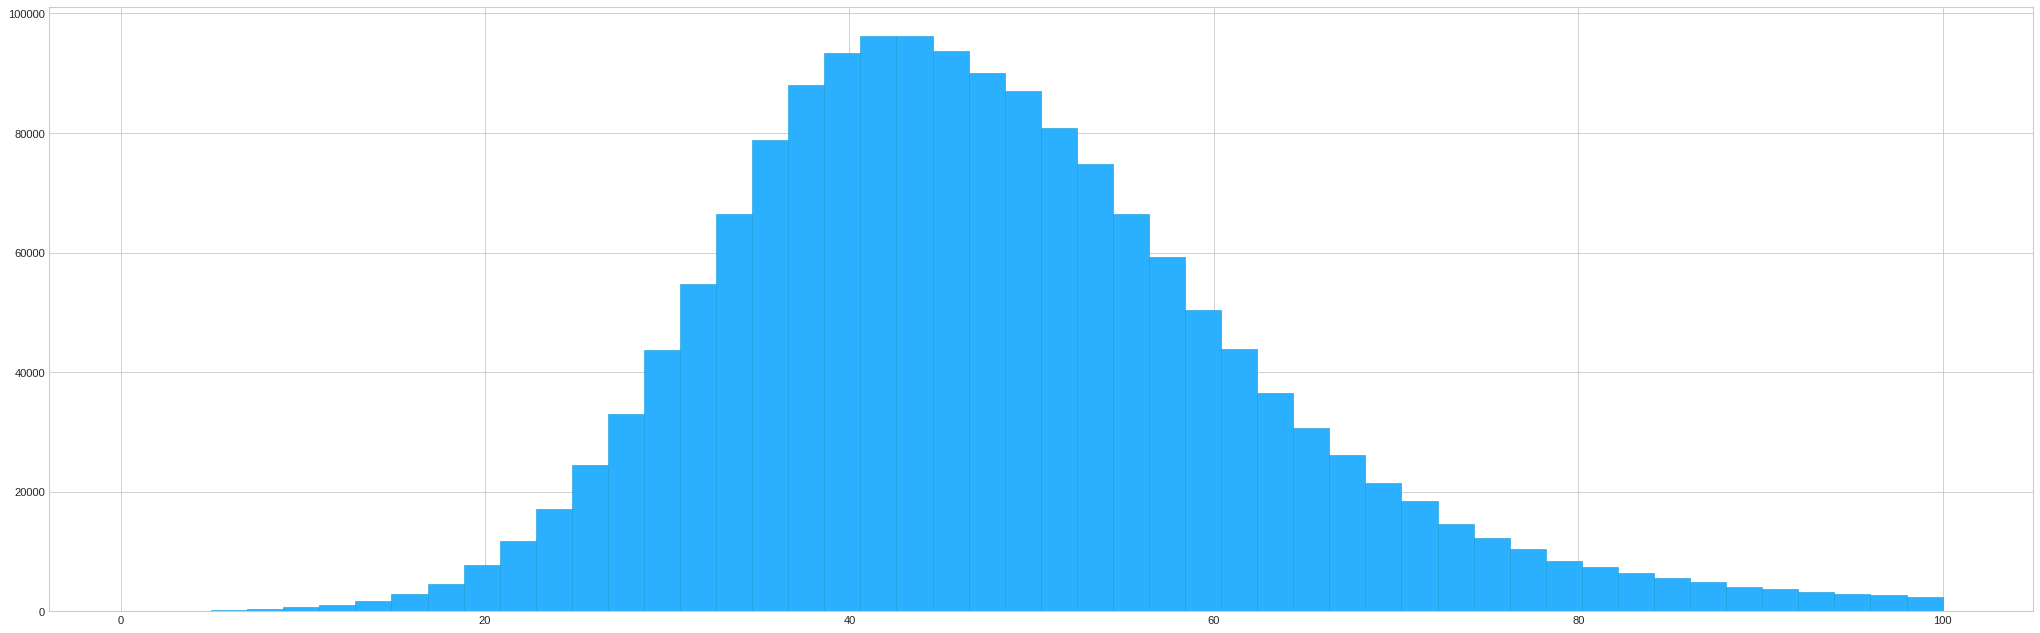

In [ ]:
import matplotlib.pyplot as plt

# distribution of molecule sequence lengths 
plt.figure(figsize=(32, 10), dpi=80)
plt.style.use('seaborn-whitegrid') 
plt.hist([len(i) for i in structures], bins=50, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

In [ ]:
def gen_structs(data):

    structs = []
    for structure in data:
        i = 0
        while i < len(structure):
            try:
                if structure[i] + structure[i+1] in elements_with_double_letters:
                    structs.append(double_to_single[structure[i] + structure[i+1]])
                    i+=2
                else:
                    structs.append(structure[i])
                    i+=1
            except:
                    structs.append(structure[i])
                    i+=1
        structs.append("$") # end token

    return structs

def gen_data(structs):

    network_inp = []
    network_outp = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(structs) - sequence_length):
        sequence_in = structs[i:i + sequence_length]
        sequence_out = structs[i + sequence_length]
        network_inp.append([element_to_int[char] for char in sequence_in])
        network_outp.append(element_to_int[sequence_out])
        
    n_patterns = len(network_inp)

    # reshape the input into a format compatible with CuDNNLSTM layers
    network_inp = np.array(network_inp, dtype="int32").reshape(n_patterns, sequence_length)

    return network_inp, np.array(network_outp, dtype="int32")

In [ ]:
num_train = 1550000
batch_siz = 50000

valid = structures[num_train:]
np.random.shuffle(valid) # changes sequences a little

train_all = structures[:num_train]
del structures
np.random.shuffle(train_all) # changes sequences a little

valid_input, valid_output = gen_data(gen_structs(valid))

In [ ]:
classes_not_in_val = [i for i in range(n_vocab) if i not in np.unique(valid_output)]
print(classes_not_in_val)
for el in classes_not_in_val:
    print(int_to_element[el])

[38, 39]
b
p


In [ ]:
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight="balanced", classes=list(range(n_vocab)), y=list(valid_output)+classes_not_in_val)
class_weights = dict(zip(range(n_vocab), class_weights))

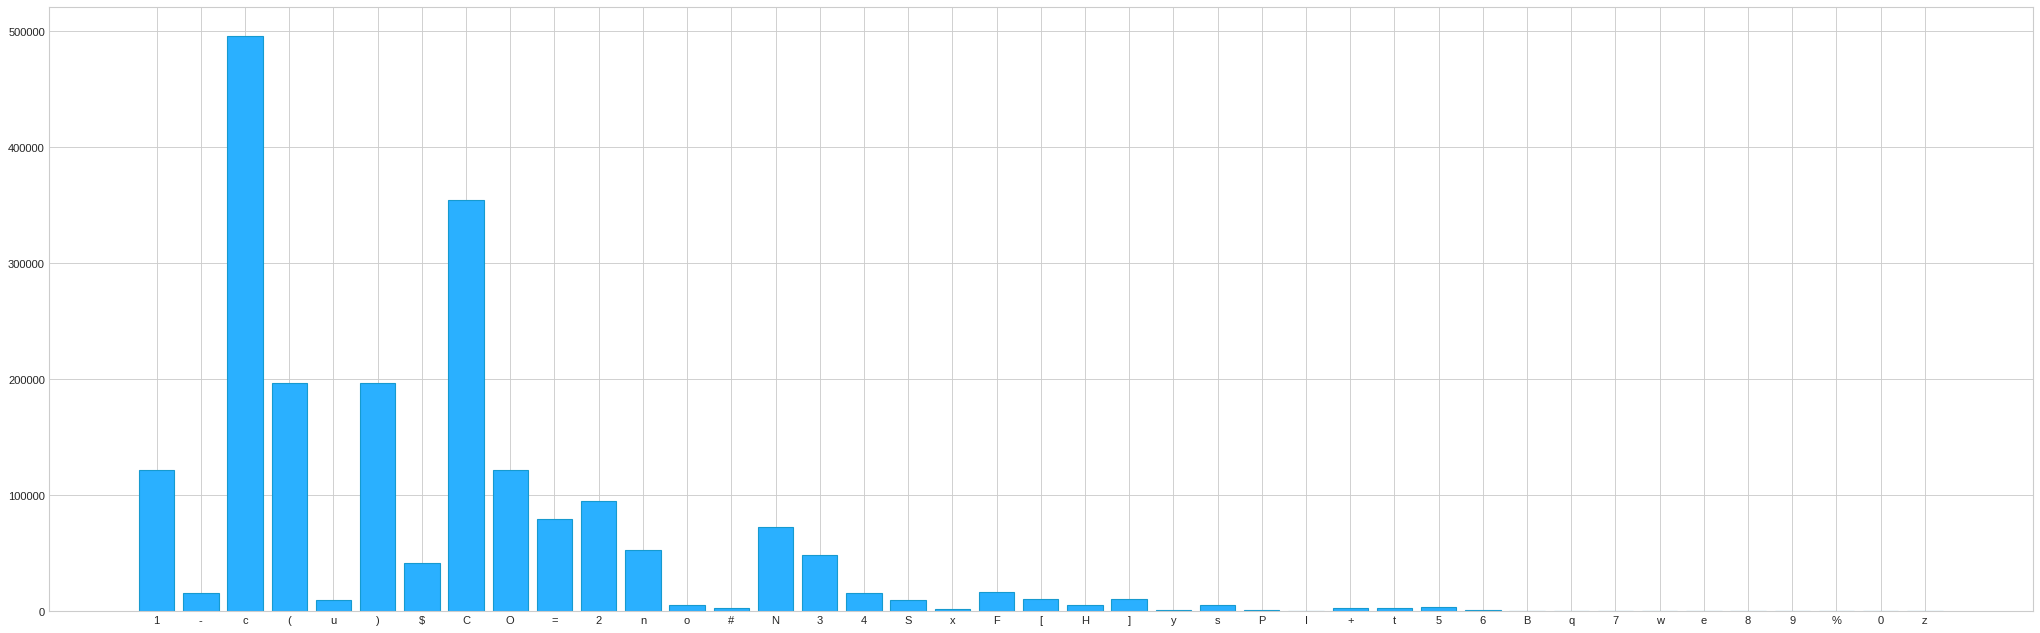

In [ ]:
from collections import Counter

# class distributions valid
c = Counter(valid_output)
plt.figure(figsize=(32, 10), dpi=80)
plt.bar([int_to_element[j] for j in c.keys()], c.values(), facecolor='#2ab0ff', edgecolor='#169acf')
plt.show()

## Model

In [ ]:
smiles_input = tf.keras.layers.Input(shape=(sequence_length,), dtype='int32', name='smiles_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_smiles = tf.keras.layers.Embedding(output_dim=12, input_dim=n_vocab, input_length=sequence_length)(smiles_input) 

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
lstm_smiles1 = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer='normal', bias_initializer='zeros')(embed_smiles)
lstm_smiles2 = tf.compat.v1.keras.layers.CuDNNLSTM(512, return_sequences=True, kernel_initializer='normal', bias_initializer='zeros')(lstm_smiles1)
lstm_smiles3 = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer='normal', bias_initializer='zeros')(lstm_smiles2)

# turn into vector
vec = tf.keras.layers.Flatten()(lstm_smiles3)
dropout_vec = tf.keras.layers.AlphaDropout(0.1)(vec)

# dense layers 
dense1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(dropout_vec)
dropout1_dense = tf.keras.layers.AlphaDropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(dropout1_dense)

# output
output = tf.keras.layers.Dense(n_vocab, activation="softmax", name='output')(dense2) 

model = tf.keras.models.Model(inputs=smiles_input, outputs=[output])

model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
smiles_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 100, 12)           516       
_________________________________________________________________
cu_dnnlstm_48 (CuDNNLSTM)    (None, 100, 256)          276480    
_________________________________________________________________
cu_dnnlstm_49 (CuDNNLSTM)    (None, 100, 512)          1576960   
_________________________________________________________________
cu_dnnlstm_50 (CuDNNLSTM)    (None, 100, 256)          788480    
_________________________________________________________________
flatten_8 (Flatten)          (None, 25600)             0         
_________________________________________________________________
alpha_dropout_31 (AlphaDropo (None, 25600)             0  

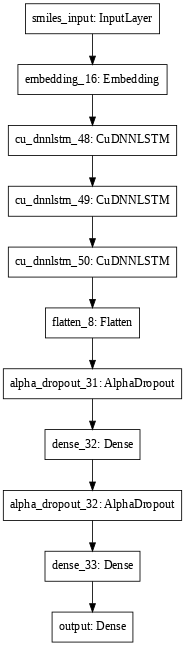

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

## Train

In [ ]:
# checkpointer
save_model_path = "SMILES-best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_model_path, 
                                                monitor='val_loss', 
                                                verbose=1,
                                                save_best_only=True)

In [ ]:
import os

# load best model
if os.path.exists(save_model_path):
    model.load_weights(save_model_path) 

In [ ]:
train_index_start = 0
train_index_end = batch_siz
while train_index_end < num_train:

    train = train_all[train_index_start:train_index_end]
    np.random.shuffle(train) # changes sequences a little

    network_input, network_output = gen_data(gen_structs(train))

    # train model on batch
    model.fit(network_input, 
              network_output, 
              validation_data=(valid_input, valid_output),
              #class_weight=class_weights,
              batch_size=128,
              shuffle=True,
              callbacks=[checkpoint])

    train_index_start += batch_siz
    train_index_end += batch_siz

In [ ]:
# if the model on the last batch wasn't the best, still save the model including the batch anyways - unless it is your final run-through
model.save_weights(save_model_path)

In [ ]:
from google.colab import files

files.download(save_model_path) 

## Molecular Analysis

In [ ]:
melatonin = "COC1=CC2=C(NC=C2CCNC(C)=O)C=C1"
glycogen = "C(C1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3C(OC(C(C3O)O)O)CO)O)O)OC4C(C(C(C(O4)CO)O)O)O)O)O)O)O"
penicillin = "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C"

In [ ]:
def test_molecule(molecule):
    if molecule == None or len(molecule) <= 3:
        return False
    mol = Chem.MolFromSmiles(molecule)
    if mol == None:
        return False
    else:
        try:
            Chem.Draw.MolToImage(mol) # if molecule is not drawable, the molecule is not valid
            return True
        except:
            return False
      
print(test_molecule(penicillin))
print(test_molecule("abc123"))

True
False


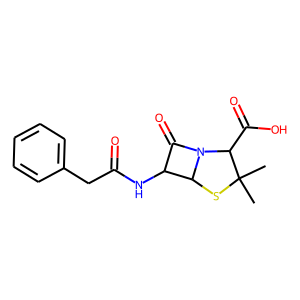

In [ ]:
def draw_compound(molecule):
    m = Chem.MolFromSmiles(molecule)
    weight = Chem.Descriptors.MolWt(m)
    return Chem.Draw.MolToImage(m)
  
draw_compound(penicillin) 

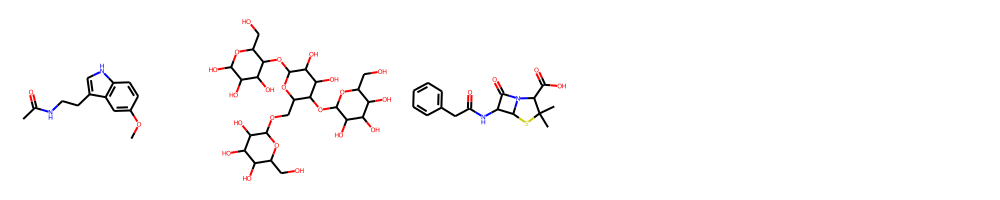

In [ ]:
def draw_list_compounds(molecules):
  list_molecules = []
  for i in molecules:
     list_molecules.append(Chem.MolFromSmiles(i))
  return Draw.MolsToGridImage(list_molecules, molsPerRow=5)

draw_list_compounds([melatonin, glycogen, penicillin])

In [ ]:
def analyze_compound(molecule):
  m = Chem.MolFromSmiles(molecule)
  print("Molecule Weight:", Chem.Descriptors.MolWt(m), "g/mol")
  print("Num Atoms:", m.GetNumAtoms())
  print("LogP:", Chem.Descriptors.MolLogP(m))
  print("TPSA:", Chem.Descriptors.TPSA(m))

analyze_compound(penicillin)

Molecule Weight: 334.39700000000005 g/mol
Num Atoms: 23
LogP: 0.8607999999999993
TPSA: 86.71000000000001


In [ ]:
def get_h_bond_donors(mol):
    idx = 0
    donors = 0
    while idx < len(mol)-1:
        if mol[idx].lower() == "o" or mol[idx].lower() == "n":
            if mol[idx+1].lower() == "h":
                donors+=1
        idx+=1
    return donors

def get_h_bond_acceptors(mol):
    acceptors = 0
    for i in mol:
        if i.lower() == "n" or i.lower() == "o":
            acceptors+=1
    return acceptors

# Lipinski's “Rule of Five” - Constraints in order to maintain drug-like character within the compounds
def rule_of_five(molecule):
    m = Chem.MolFromSmiles(molecule)
    if get_h_bond_donors(molecule) <= 5 and get_h_bond_acceptors(molecule) <= 10 and Chem.Descriptors.MolWt(m) <= 500 and Chem.Descriptors.MolLogP(m) <= 5:
        return True
    else:
        return False

print(rule_of_five(melatonin))
print(rule_of_five(glycogen))
print(rule_of_five(penicillin))

True
False
True


In [ ]:
def similarity(molecule1, molecule2): # fraction of fingerprints the set of two molecules have in common
    m1 = Chem.MolFromSmiles(molecule1)
    bi1 = {}
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, radius=2, nBits=2048, bitInfo=bi1)
    fp1_bits1 = fp1.GetOnBits()

    m2 = Chem.MolFromSmiles(molecule2)
    bi2 = {}
    fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, radius=2, nBits=2048, bitInfo=bi2)
    fp2_bits2 = fp2.GetOnBits()

    common = set(fp1_bits1) & set(fp2_bits2)
    combined = set(fp1_bits1) | set(fp2_bits2)

    return len(common)/len(combined) # recreation of DataStructs.TanimotoSimilarity

similarity(melatonin, penicillin)

0.1388888888888889

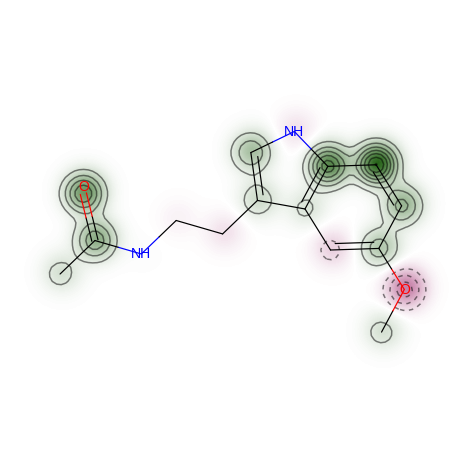

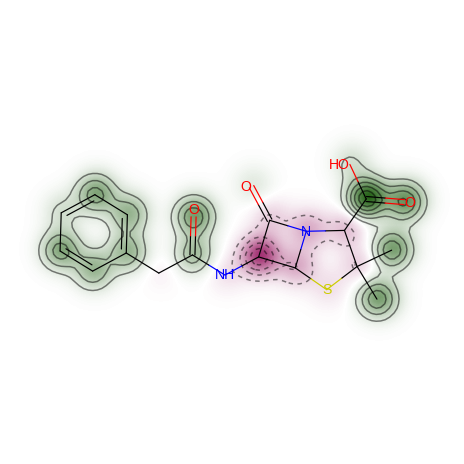

In [ ]:
def similarity_map(molecule1, molecule2):

    m1 = Chem.MolFromSmiles(molecule1)
    m2 = Chem.MolFromSmiles(molecule2)

    fig1, maxweight1 = Chem.Draw.SimilarityMaps.GetSimilarityMapForFingerprint(m2, m1, Chem.Draw.SimilarityMaps.GetMorganFingerprint)
    fig2, maxweight2 = Chem.Draw.SimilarityMaps.GetSimilarityMapForFingerprint(m1, m2, Chem.Draw.SimilarityMaps.GetMorganFingerprint)

similarity_map(melatonin, penicillin)

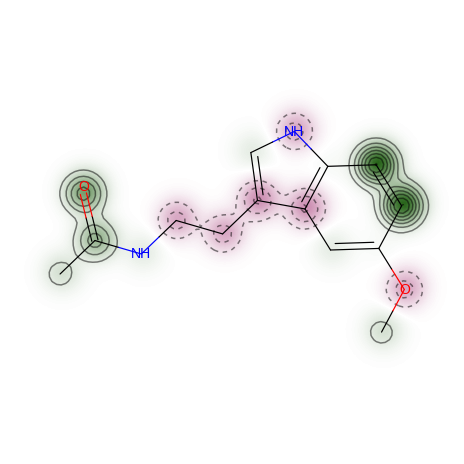

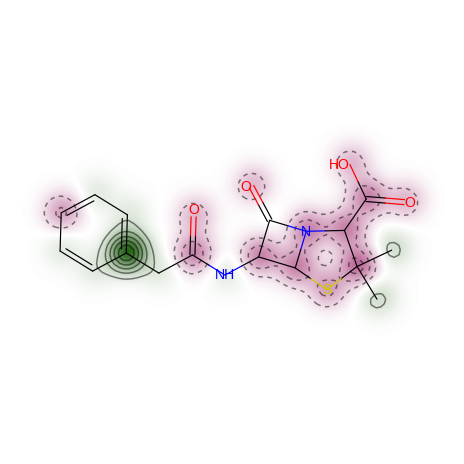

In [ ]:
def similarity_map_tanimoto(molecule1, molecule2, r):

    m1 = Chem.MolFromSmiles(molecule1)
    m2 = Chem.MolFromSmiles(molecule2)

    fig3, maxweight3 = Chem.Draw.SimilarityMaps.GetSimilarityMapForFingerprint(m2, m1, lambda m,idx: Chem.Draw.SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=r, fpType='count'), metric=DataStructs.TanimotoSimilarity)
    fig4, maxweight4 = Chem.Draw.SimilarityMaps.GetSimilarityMapForFingerprint(m1, m2, lambda m,idx: Chem.Draw.SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=r, fpType='count'), metric=DataStructs.TanimotoSimilarity)

similarity_map_tanimoto(melatonin, penicillin, 1)

## Sample & Load Data For Model Testing

In [ ]:
filey = open('pharmaceuticAI_all_compounds.smiles')
structures = [line[:-1] for line in filey]
print("Num Total Samples:", len(structures))
filey.close()

num_sampled = 10000
np.random.shuffle(structures)
data = structures[:num_sampled]
print("Num Sampled:", num_sampled)

network_input, _ = gen_data(gen_structs(data))
del structures

Num Total Samples: 1591378
Num Sampled: 10000


## Generate Random Compounds

In [ ]:
def generate(num_molecules=100):

    new_molecules = []

    while len(new_molecules) != num_molecules: # repeat until num_molecules molecules are generated

        start = np.random.randint(0, len(network_input)-1)
        pattern = network_input[start] # grab a random sequence

        prediction_output = []

        try:
            start_idx = len(list(pattern)) - list(pattern)[::-1].index(element_to_int["$"]) - 1 # get index of last "$" (end token) which is the start of the incomplete molecule built upon
        except:
            start_idx = 0 # in case input does not even have an end token and is just one long molecule
        start_mol = list(pattern)[start_idx+1:]
        for element in start_mol:
            prediction_output.append(int_to_element[element]) # add incomplete molecule to start of output

        # build upon the incomplete molecule with predictions (predicting the next element of the sequence)
        # will stop at 100 predictions or until the end token "$" is predicted
        for element_index in range(100):
            prediction_input = np.reshape(pattern, (1, len(pattern)))
            prediction_input = prediction_input
            prediction = model.predict(prediction_input, verbose=0)
            index = np.argmax(prediction)
            result = int_to_element[index]
            if result == "$":
                break
            prediction_output.append(result)
            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]

        output = "".join(prediction_output)

        for word, initial in single_to_double.items(): 
            output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements   

        if output not in new_molecules and test_molecule(output) and rule_of_five(output): # make sure that the molecules are unique, valid, and drug-like
              print("generated (randomly)", output)
              new_molecules.append(output)

    return new_molecules

In [ ]:
new_molecules = generate(10)

In [ ]:
draw_list_compounds(new_molecules)

## Test Performance

In [ ]:
def test_performance(num_molecules=1000):

    new_molecules = []

    valid = 0
    drug_like = 0

    for k in range(num_molecules): # repeat until num_molecules molecules are generated

        start = np.random.randint(0, len(network_input)-1)
        pattern = network_input[start] # grab a random sequence

        prediction_output = []

        try:
            start_idx = len(list(pattern)) - list(pattern)[::-1].index(element_to_int["$"]) - 1 # get index of last "$" (end token) which is the start of the incomplete molecule built upon
        except:
            start_idx = 0 # in case input does not even have an end token and is just one long molecule
        start_mol = list(pattern)[start_idx+1:]
        for element in start_mol:
            prediction_output.append(int_to_element[element]) # add incomplete molecule to start of output

        # build upon the incomplete molecule with predictions (predicting the next element of the sequence)
        # will stop at 100 predictions or until the end token "$" is predicted
        for element_index in range(100):
            prediction_input = np.reshape(pattern, (1, len(pattern)))
            prediction_input = prediction_input
            prediction = model.predict(prediction_input, verbose=0)
            index = np.argmax(prediction)
            result = int_to_element[index]
            if result == "$":
                break
            prediction_output.append(result)
            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]

        output = "".join(prediction_output)

        for word, initial in single_to_double.items(): 
            output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements
          
        if test_molecule(output):
            valid+=1
        
        if rule_of_five(output): 
            drug_like+=1

    return num_molecules, valid, drug_like

In [ ]:
a,b,c = test_performance()
print("out of", a, "molecules generated,", b, "molecules were valid and", c, "molecules were drug-like")

## Complete The Rest Of A Molecule

In [ ]:
def complete_molecule(inp):

    for word, initial in double_to_single.items(): 
        inp = inp.replace(word, initial) # replace double-letter elements to single-letter for model input

    net_inp = []

    for i in range(0, len(inp)):
        seq_in = inp[i]
        net_inp.append([element_to_int[char] for char in seq_in])

    found = False
    while not found:
        start = np.random.randint(0, len(network_input)-1)
        sample = network_input[start]
        if int_to_element[np.round(sample[-1])] == "$":
            found = True

    sample = sample[len(inp):sequence_length]

    net_in = []
    for i in sample:
      net_in.append(i)
    for j in net_inp:
      net_in.append(j[0])

    net_input = np.reshape(net_in[-sequence_length:], (1, sequence_length))[0]

    pred_out = []
    for element_index in range(100):
        net_input = np.reshape(net_in[-sequence_length:], (1, sequence_length))
        prediction = model.predict(net_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_element[index]
        pred_out.append(result)
        net_input = np.append(net_input, index)
        net_input = net_input[1:len(net_input)]

    output = "".join(pred_out)

    for word, initial in single_to_double.items(): 
        output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements

    end_molecule = ""
    for i in range(0, len(output)):
        if output[i] == "$":
          end_molecule = output[:i]
          break

    molecule = inp + end_molecule
    return molecule

In [ ]:
melatonin

'COC1=CC2=C(NC=C2CCNC(C)=O)C=C1'

In [ ]:
molecule = complete_molecule(str(input()))
print(molecule)

In [ ]:
analyze_compound(molecule)

In [ ]:
draw_compound(molecule)

## Generate Compounds Methodically Using Inhibitors of Coronavirus

In [ ]:
import pandas as pd

target = new_client.target
target_query = target.search('coronavirus') # search for target protein
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


In [ ]:
selected_target = targets.target_chembl_id[4] # SARS coronavirus 3C-like proteinase	
selected_target

'CHEMBL3927'

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="Inhibition")
df = pd.DataFrame.from_dict(res)
df.head(20)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480934,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,None,None,BAO_0000201,BAO_0000357,single protein format,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C(N)=O)ccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL372889,None,CHEMBL372889,None,False,http://qudt.org/vocab/unit#Percent,384102,=,1,True,=,None,Inhibition,%,None,25.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,25.0
1,None,1481062,[],CHEMBL832053,In vitro percent inhibition against SARS coron...,B,None,None,BAO_0000201,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL188484,None,CHEMBL188484,None,False,http://qudt.org/vocab/unit#Percent,383987,=,1,True,=,None,Inhibition,%,None,13.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,13.0
2,None,1481063,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,None,None,BAO_0000201,BAO_0000357,single protein format,COc1ccc2c(c1)C(=O)C(=O)N2Cc1cc2ccccc2o1,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL362781,None,CHEMBL362781,None,False,http://qudt.org/vocab/unit#Percent,383988,=,1,True,=,None,Inhibition,%,None,13.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,13.0
3,None,1481064,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,None,None,BAO_0000201,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc([N+](=O)[O-])cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL191322,None,CHEMBL191322,None,False,http://qudt.org/vocab/unit#Percent,384074,=,1,True,=,None,Inhibition,%,None,24.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,24.0
4,None,1481067,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,None,None,BAO_0000201,BAO_0000357,single protein format,Nc1cccc2c1N(Cc1cc3ccccc3s1)C(=O)C2=O,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL363243,None,CHEMBL363243,None,False,http://qudt.org/vocab/unit#Percent,384178,=,1,True,=,None,Inhibition,%,None,31.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,31.0
5,None,1481072,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,None,None,BAO_0000201,BAO_0000357,single protein format,Cc1cc2c(c([N+](=O)[O-])c1)N(Cc1cc3ccccc3s1)C(=...,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL365677,None,CHEMBL365677,None,False,http://qudt.org/vocab/unit#Percent,384006,=,1,True,=,None,Inhibition,%,None,39.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,39.0
6,None,1481073,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,None,None,BAO_0000201,BAO_0000357,single protein format,COc1ccc2c(c1)C(=O)C(=O)N2Cc1cc2ccccc2s1,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL188811,None,CHEMBL188811,None,False,http://qudt.org/vocab/unit#Percent,384007,=,1,True,=,None,Inhibition,%,None,27.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhib

In [ ]:
df.assay_description.unique() # make sure all of them are inhibitors - inhibitors stop the function of the protein (turn it off - opposite of activators)

array(['In vitro percent inhibition against SARS coronavirus main protease (SARS CoV 3C-like protease) at 20 uM',
       'In vitro percent inhibition against SARS coronavirus main protease (SARS CoV 3C-like protease)',
       'Inhibition of Mpro in SARS-CoV at 100uM',
       'Inhibition of Mpro in SARS-CoV at 100 uM in FRET-based assay',
       'Inhibition of Mpro in SARS-CoV at 100 uM in HPLC assay',
       'Inhibition of SARS CoV 3C-like protease at 100 uM',
       'Inhibition of SARS coronavirus main protease at 10 uM',
       'Inhibition of SARS coronavirus His-3C-like protease at 100 uM',
       'Inhibition of SARS coronavirus 3C-like protease at 1 uM',
       'Inhibition of SARS-CoV 3CLpro expressed in Escherichia coli BL21 (DE3) using Dabcyl-KNSTLQSGLRKE-Edan as substrate at 200 uM after 60 mins by FRET analysis',
       'Inhibition of SARS-CoV PLpro deubiququitination expressed in Escherichia coli BL21 (DE3) using Arg-Leu-Arg-Gly-Gly-AMC as substrate at 200 uM by fluorescence a

In [ ]:
target_inhibit_list = df.canonical_smiles 
target_inhibit_list = list(set(target_inhibit_list)) # remove duplicates
print(target_inhibit_list)

['O=C(Nc1ccncc1)c1cccs1', 'COC(=O)C1C(c2ccccc2)N1Cc1ccccc1', 'Cc1ccc(OC(=O)c2cccs2)cn1', 'O=C(Nc1ccc(F)cc1F)c1ccc(CN2C(=O)C(=O)c3cc(I)ccc32)s1', 'COC(=O)C1CN1[C@@H](CC(=O)OCc1ccccc1)C(=O)OCc1ccccc1', 'O=C(Nc1ccccn1)c1cccs1', 'Cc1ccc(OC(=O)c2cccs2)c([N+](=O)[O-])n1', 'COC(=O)C1CN1CC(=O)OCc1ccccc1', 'COC(=O)CN1CC1C(=O)OC', 'CC(C)NC(=O)c1ccc(CN2C(=O)C(=O)c3cc(I)ccc32)s1', 'CCCCN1C(=O)C(=O)c2cc(C(=O)OC)ccc21', 'CC(C)C[C@@H]1O[C@@H]1[C@H](Cc1ccccc1)NC(=O)OC(C)(C)C', 'Cc1coc2c1C(=O)C(=O)c1c-2ccc2c1CCCC2(C)C', 'O=C(Oc1ccccn1)c1cccs1', 'CN1C(=O)C(=O)c2cc(I)ccc21', 'COC(=O)C1(C(=O)OC)NC1C', 'C[C@H]1O[C@H]1C(=O)N[C@@H](Cc1ccccc1)C(=O)O', 'Cc1cc2c(c([N+](=O)[O-])c1)N(CC(=O)c1cc3ccccc3s1)C(=O)C2=O', 'O=C(Oc1cccc(Cl)c1)c1ccco1', 'O=C(Oc1cncc(Cl)c1)c1ccco1', 'O=C(Oc1cncc(Cl)c1)c1ccccc1', 'O=C1Nc2ccc(I)cc2C1=O', 'COC(=O)c1ccc2c(c1)C(=O)C(=O)N2C', 'CC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C[C@@H]1CCNC1=O)C(=O)c1cccs1)[C@@H](C)O)C(C)C', 'Cc1cccc(OC(=O)c2cccs2)n1', 'COC(=O)[C@@]1(C)CCCc

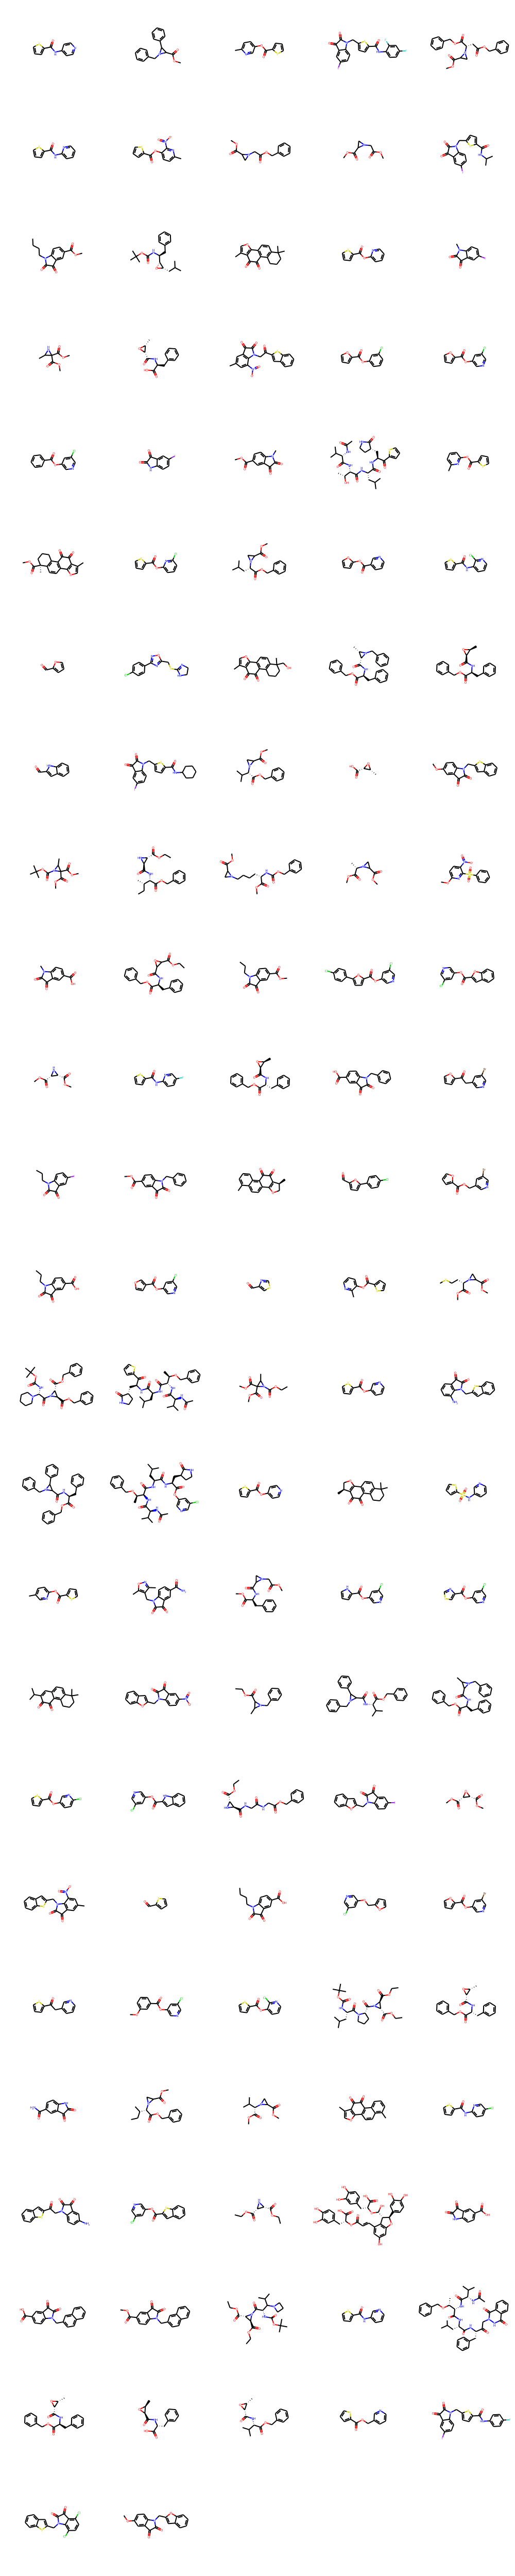

In [ ]:
draw_list_compounds(target_inhibit_list)

In [ ]:
def generate_methodical(target_inhibitors_list):

    target_inhibitors = [inhibitor.replace("/", "").replace("@", "").replace("\\", "").replace(".", "") for inhibitor in target_inhibitors_list]

    inhibitors_sequences = []
    for mol in target_inhibitors:
        for cutoff in range(1, len(mol)): 
            inhibitors_sequences.append(mol[:cutoff])

    new_molecules = []
    for seq in inhibitors_sequences:
        new_mol = complete_molecule(seq)
        if new_mol not in new_molecules: # make sure that the molecules are unique
          if test_molecule(new_mol) and rule_of_five(new_mol): # make sure that the molecules are valid and drug-like
              new_molecules.append(new_molecules.append(new_mol))
              print("generated (methodically)", new_mol)

    return new_molecules

In [ ]:
new_molecules = generate_methodical(target_inhibit_list)

In [ ]:
draw_list_compounds(new_molecules[:100])

## Augment Existing Molecules

In [ ]:
def complete(inp): # helper method for augment - returns a prediction in place of the removed element

    for word, initial in double_to_single.items(): 
        inp = inp.replace(word, initial) # replace double-letter elements to single-letter for model input

    net_inp = []

    for i in range(0, len(inp)):
        seq_in = inp[i]
        net_inp.append([element_to_int[char] for char in seq_in])

    found = False
    while not found: # find sequence with the end token "$" at the end
        start = np.random.randint(0, len(network_input)-1)
        pattern = network_input[start]
        if int_to_element[np.round(pattern[-1])] == "$":
            found = True

    net_in = []
    for i in pattern[len(inp):sequence_length]:
      net_in.append(i)
    for j in net_inp:
      net_in.append(j[0])

    net_in = np.reshape(net_in[-sequence_length:], (1, sequence_length))

    prediction = model.predict(net_in, verbose=0) # make prediction
    index = np.argmax(prediction)
    result = int_to_element[index]

    return result

def augment(compound, num_changes): # could enhance the pharmacokinetics and bioactivity of the compound

    for word, initial in double_to_single.items(): 
        compound = compound.replace(word, initial) # replace double-letter elements to single-letter for model input

    changes = np.random.randint(1, num_changes+1)
    for i in range(0, changes): # randomly removes certain amount of random elements in SMILES string compound and replaces them with prediction
        ind = np.random.randint(0, len(compound))
        changed = compound[ind]
        new_compound = compound[:ind]
        
        result = complete(new_compound)
        if result == "$":
            return compound[:ind] # if an end token is predicted, return the part of the compound up to the changed index
        else:
            compound = compound[:ind] + result + compound[ind+1:] # add the prediction in place of the removed element

    return compound # return the augmented compound after all the changes have been made

def augment_repeat(inp, sim, changes, max_try):

  if len(inp) > sequence_length:
      inp = inp[:sequence_length]

  tries = 0
  while tries < max_try: # keep trying to make augmented molecules until the model has exceeded the max number of tries (max_try)

      augmented = augment(inp, changes)
      tries += 1 
      for word, initial in single_to_double.items(): 
        augmented = augmented.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements
      try:
          if test_molecule(augmented) and augmented != inp and rule_of_five(augmented): # make sure that the molecules are valid and drug-like
              s = similarity(inp, augmented) # calculate similarity between the original molecule and the augmented molecule
              if sim < s < 1: # make sure the molecule follows the similarity threshold
                  print("augmented", inp, "-->", augmented, "with similarity", s)
                  return augmented
      except:
          continue

  print("could not augment", inp, "within", tries, "tries")

def aug_list(inp_list, similarity=0.2, max_changes=20, max_tries=100):

    molecules = [augment_repeat(compound.replace('/', "").replace('@', "").replace('\\', "").replace('.', ""), similarity, max_changes, max_tries) for compound in inp_list]
    molecules = list(set(molecules)) # remove duplicates
    molecules = [i for i in molecules if i] 
    return molecules

In [ ]:
melatonin

'COC1=CC2=C(NC=C2CCNC(C)=O)C=C1'

In [ ]:
original = str(input())
augmented = aug_list([original])[0]

In [ ]:
draw_compound(augmented)

In [ ]:
draw_compound(original)

In [ ]:
similarity(original, augmented)

In [ ]:
similarity_map(original, augmented)

In [ ]:
similarity_map_tanimoto(original, augmented, 1)

# Train 1D CNN Model To Predict Binding Affinity 

## Imports and Installations

In [ ]:
# install conda on google colab
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
!conda install -q -c rdkit rdkit -y # for molecule analysis and visualization

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps

# suppress rdkit error/warning messages
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.warning')

In [ ]:
import numpy as np
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data - BindingPD

In [ ]:
!unzip -q -o "ic50_affinity_data.zip"

In [ ]:
import pandas as pd

data = pd.read_csv("ic50_affinity_data.csv")
data.head()

,compound_id,target_id,smiles,fasta,standard_value
0,CHEMBL341267,P70536,CC1(C)C2CC[C@]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5cccc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,2400.0
1,CHEMBL126962,P70536,CC1(C)C2CC[C@@]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5ccc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,1800.0
2,CHEMBL420144,P70536,CC1(C)[C@@H]2CC[C@@]1(CS(=O)(=O)N3CCC4(CC3)C=C...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,1800.0
3,CHEMBL2047680,Q9UBN7,N\N=C(/Cc1ccc(O)c(Br)c1)\C(=O)NCCS,MTSTGQDSTTTRQRRSRQNPQSPPQDSSVTSKRNIKKGAVPRSIPN...,1000.0
4,CHEMBL2047680,Q9BY41,N\N=C(/Cc1ccc(O)c(Br)c1)\C(=O)NCCS,MEEPEEPADSGQSLVPVYIYSPEYVSMCDSLAKIPKRASMVHSLIE...,13000.0


In [ ]:
data = data[~data.smiles.str.contains("\*")]
data = data[~data.smiles.str.contains("%")]
data = data[~data.smiles.str.contains(":")]
data = data[~data.fasta.str.contains('\d')]
data.fasta = data.fasta.apply(lambda x: x.replace(" ", ""))
data.standard_value = data.standard_value.apply(lambda x: str(x).replace(">", "").replace("<", "")).astype("float32")
data.standard_value.describe()

count    5.210360e+05
mean     3.715030e+15
std               inf
min     -4.190000e+04
25%      3.000000e+01
50%      3.784000e+02
75%      4.500000e+03
max      1.000000e+21
Name: standard_value, dtype: float64

In [ ]:
print("Num Interactions:", len(data))
print("Num Proteins:", len(data.fasta.unique()))
print("Num Ligands:", len(data.smiles.unique()))

Num Interactions: 521036
Num Proteins: 3954
Num Ligands: 346961


In [ ]:
smiles = []
for mol in data.smiles:
    smiles.append(mol.replace('/', "").replace('@', "").replace('\\', "").replace('.', "").replace("|", "").replace(" ", ""))
data.smiles = smiles
del smiles
data.head()

,compound_id,target_id,smiles,fasta,standard_value
0,CHEMBL341267,P70536,CC1(C)C2CC[C]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5ccccc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,2400.0
1,CHEMBL126962,P70536,CC1(C)C2CC[C]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5ccccc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,1800.0
2,CHEMBL420144,P70536,CC1(C)[CH]2CC[C]1(CS(=O)(=O)N3CCC4(CC3)C=Cc5cc...,MEGTPAANWSVELDLGSGVPPGEEGNRTAGPPQRNEALARVEVAVL...,1800.0
3,CHEMBL2047680,Q9UBN7,NN=C(Cc1ccc(O)c(Br)c1)C(=O)NCCS,MTSTGQDSTTTRQRRSRQNPQSPPQDSSVTSKRNIKKGAVPRSIPN...,1000.0
4,CHEMBL2047680,Q9BY41,NN=C(Cc1ccc(O)c(Br)c1)C(=O)NCCS,MEEPEEPADSGQSLVPVYIYSPEYVSMCDSLAKIPKRASMVHSLIE...,13000.0


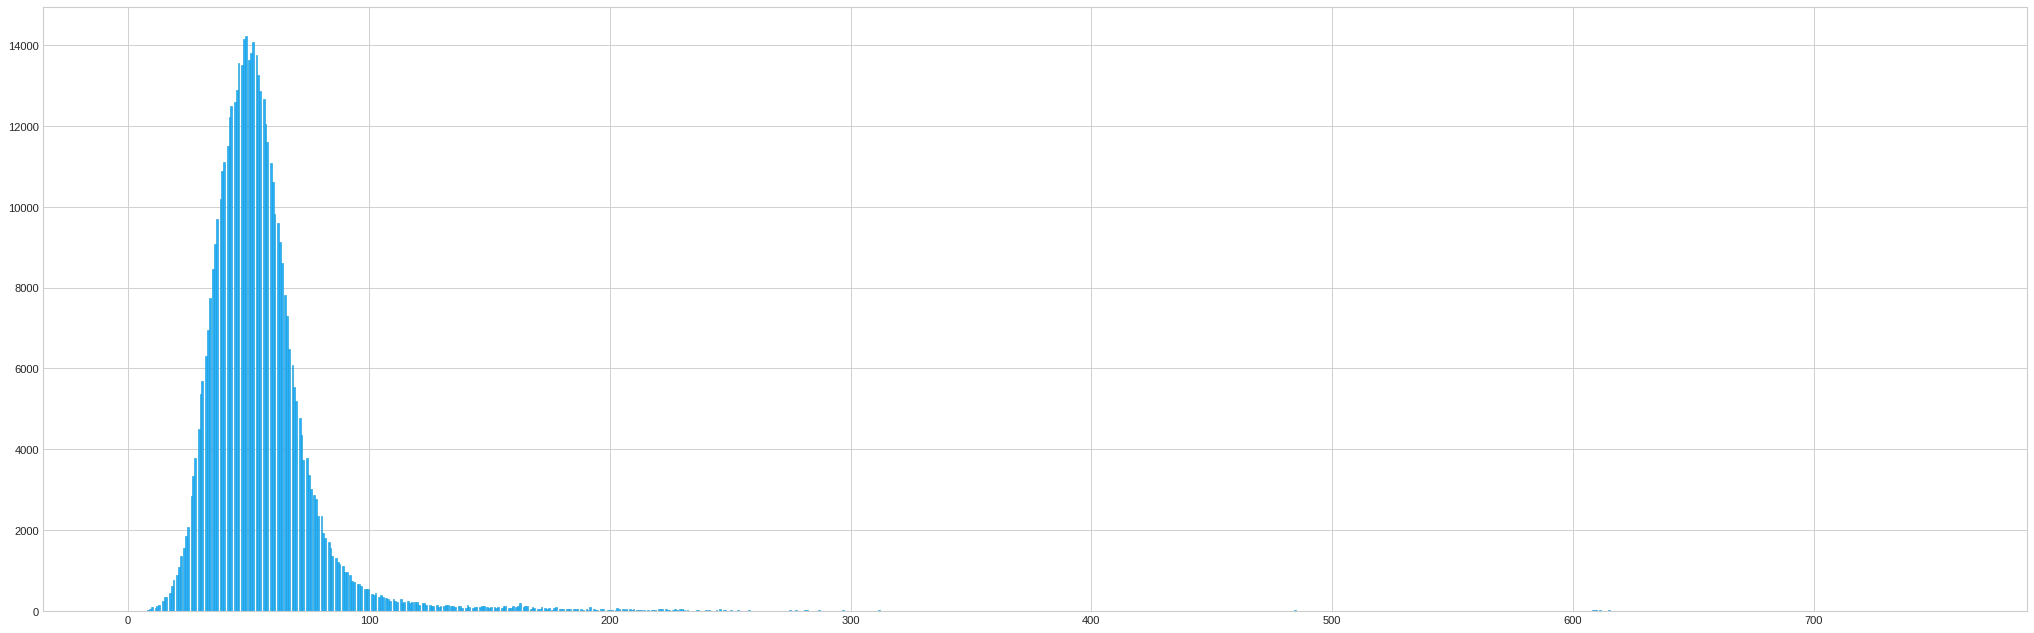

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 10), dpi=80)
plt.style.use('seaborn-whitegrid') 
plt.hist(data.smiles.str.len(), bins=1000, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

In [ ]:
# remove rows with molecule SMILES length greater than max_smiles
max_smiles = 100
data.drop(data[data["smiles"].map(len) > max_smiles].index, inplace=True)
data = data.reset_index(drop=True)
len(data) 

504597

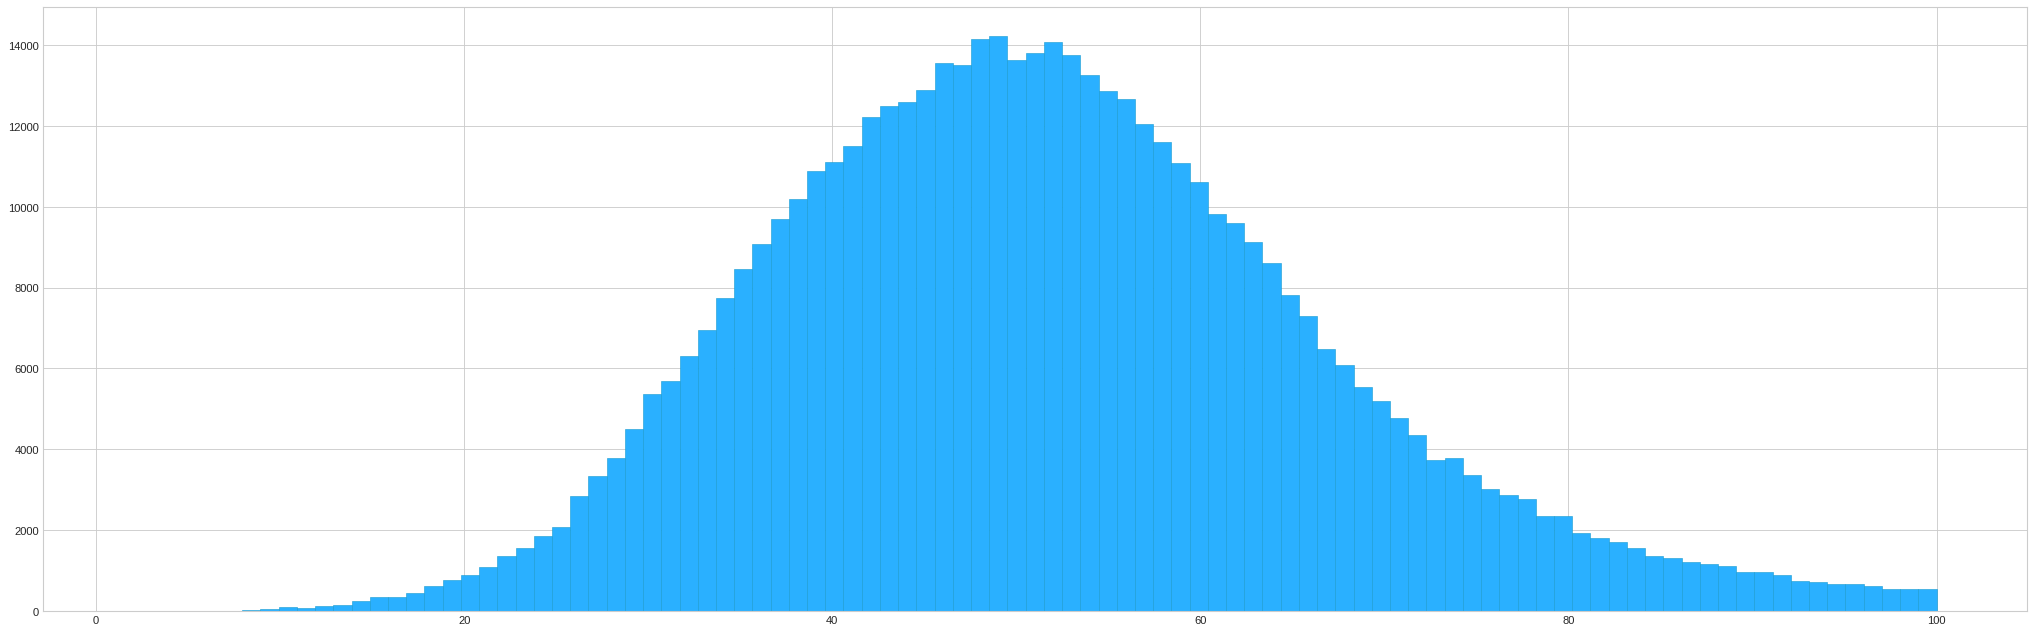

In [ ]:
plt.figure(figsize=(32, 10), dpi=80)
plt.style.use('seaborn-whitegrid') 
plt.hist(data.smiles.str.len(), bins=99, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

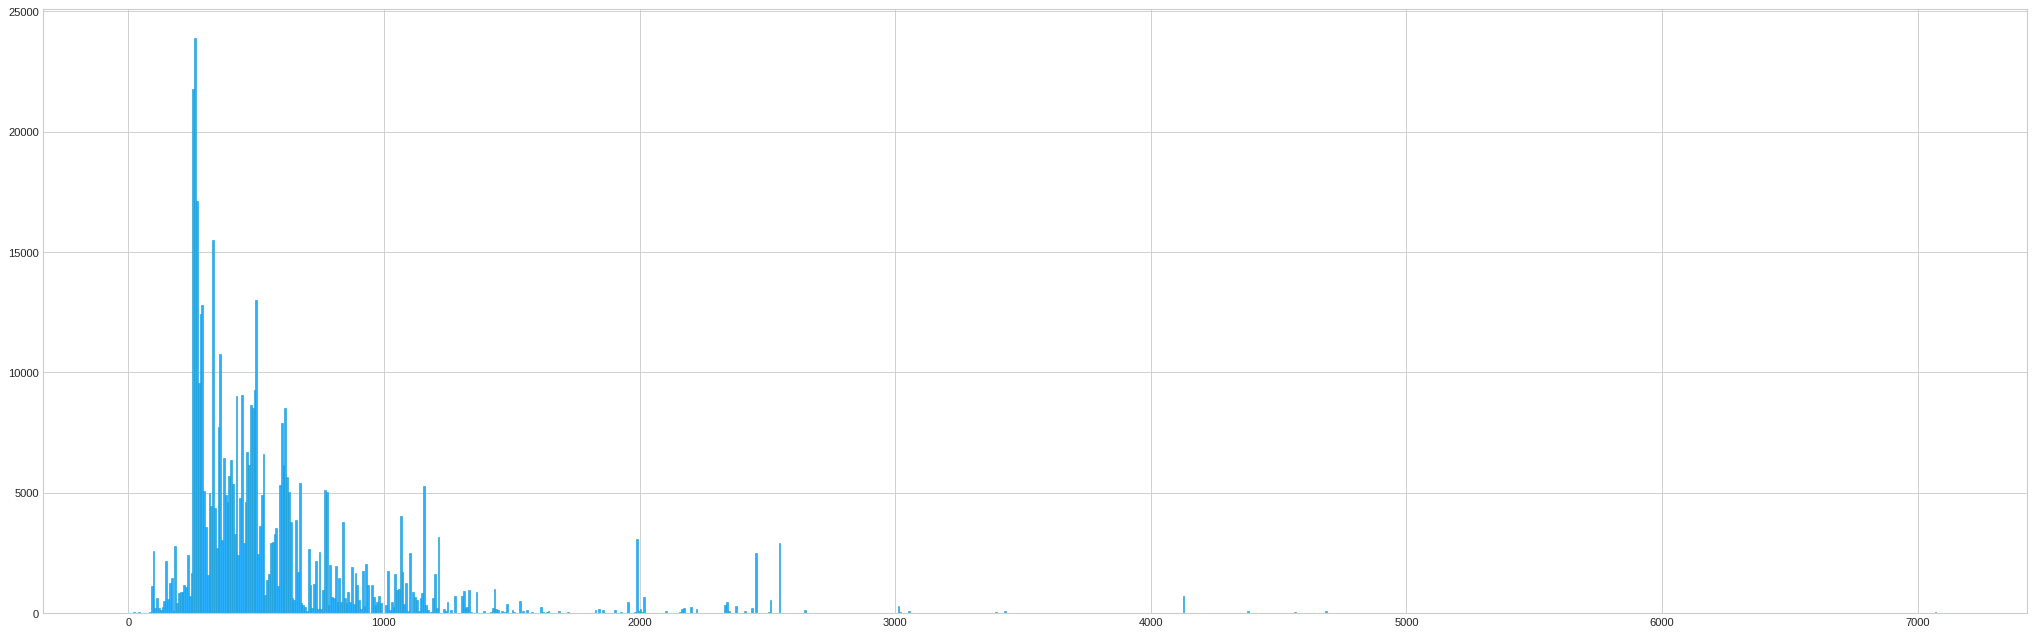

In [ ]:
plt.figure(figsize=(32, 10), dpi=80)
plt.style.use('seaborn-whitegrid') 
plt.hist(data.fasta.str.len(), bins=1000, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

In [ ]:
# remove rows with molecule SMILES length greater than max_fasta
max_fasta = 5000
data.drop(data[data["fasta"].map(len) > max_fasta].index, inplace=True)
data = data.reset_index(drop=True)
len(data) 

504520

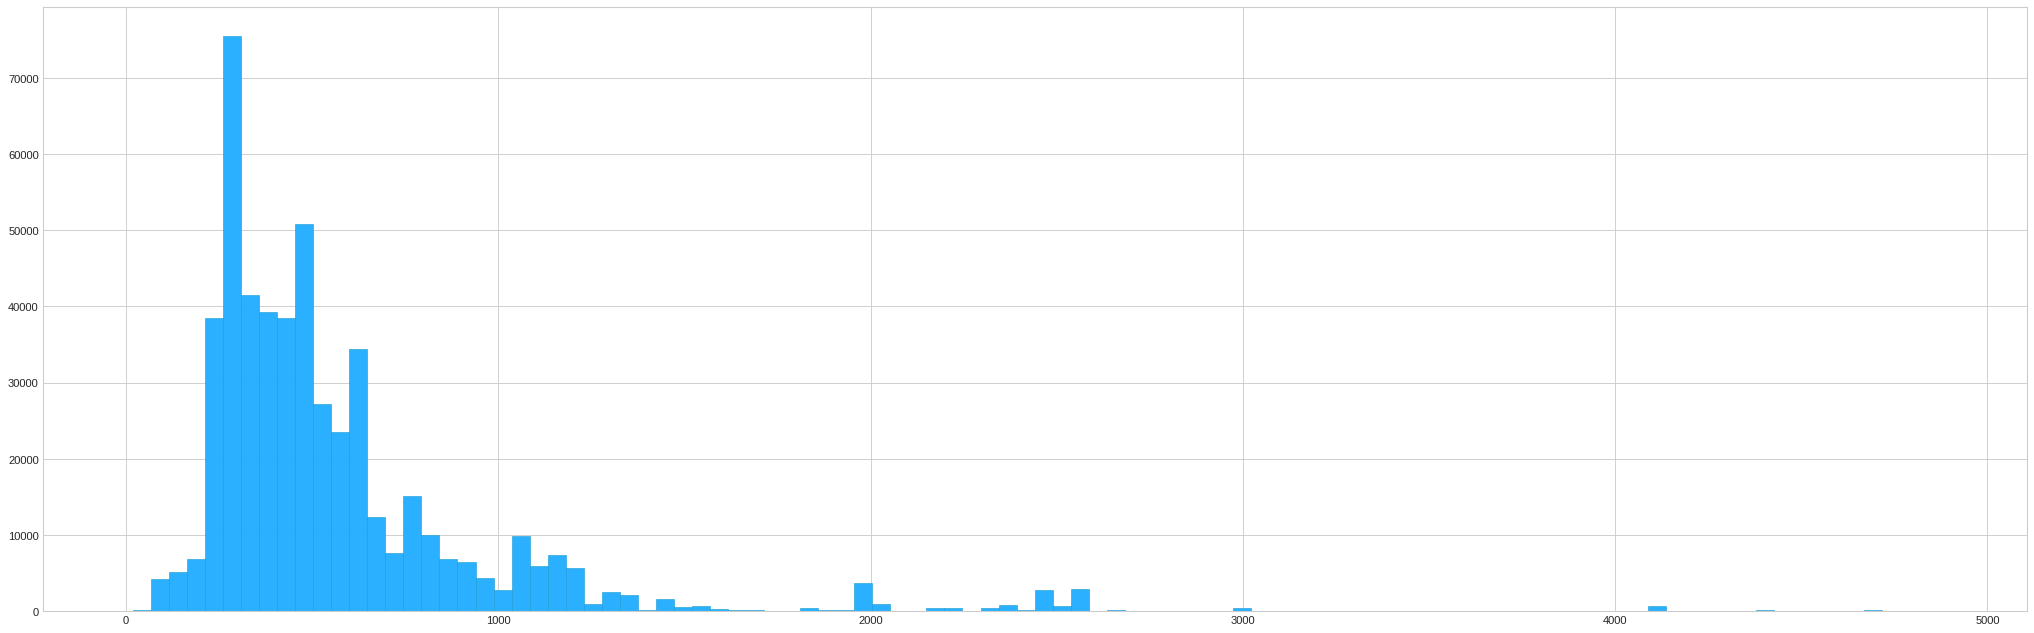

In [ ]:
plt.figure(figsize=(32, 10), dpi=80)
plt.style.use('seaborn-whitegrid') 
plt.hist(data.fasta.str.len(), bins=100, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

In [ ]:
# remove negative IC50 values or 0's
data.drop(data[data["standard_value"] <= 0.0].index, inplace=True)
data = data.reset_index(drop=True)
len(data) 

503984

In [ ]:
# convert to pIC50 values - negative log IC50
data.standard_value = [-np.log(val*1e-9) for val in data.standard_value] # convert from nM to M --> then negative log
data.standard_value.describe()

count    503984.000000
mean          3.112704
std           3.431234
min         -39.354287
25%           0.572458
50%           3.038995
75%           5.598803
max          31.332704
Name: standard_value, dtype: float64

In [ ]:
plt.figure(figsize=(32, 10), dpi=80)
plt.style.use('seaborn-whitegrid') 
plt.hist(data.standard_value, bins=100, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

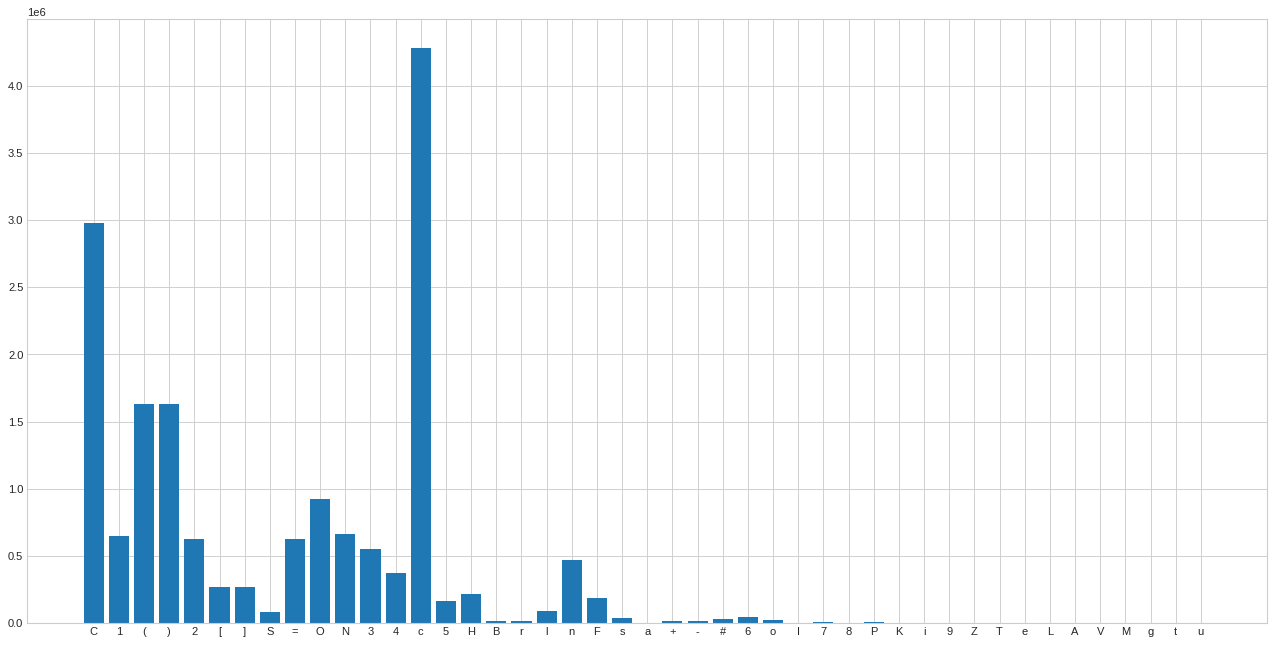

In [ ]:
from collections import Counter

# element distribution in unique molecules (SMILES)
chars = []
for seq in data.smiles.unique():
    for char in seq:
        chars.append(char)
c = Counter(chars)
del chars
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([i for i in c.keys()], c.values())
plt.show()

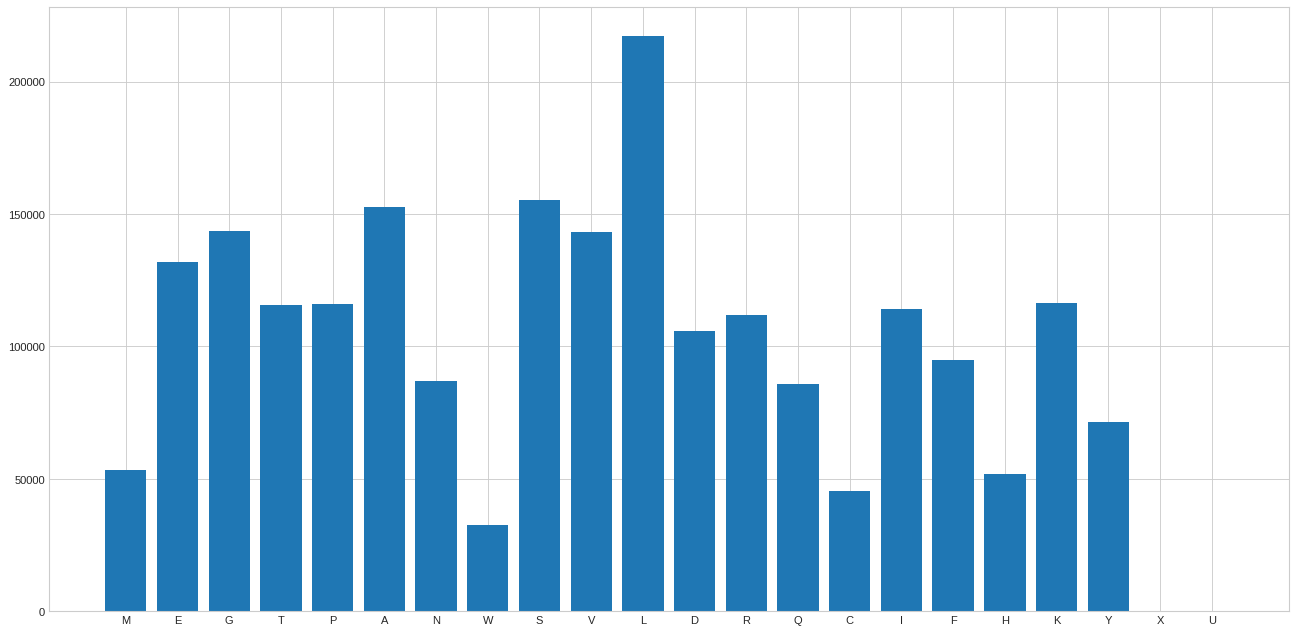

In [ ]:
# amino acid distribution in unique protein sequences
letters = []
for seq in data.fasta.unique():
    for letter in seq.upper():
        letters.append(letter)
c = Counter(letters)
del letters
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([i for i in c.keys()], c.values())
plt.show()

### Add Features

In [ ]:
def get_coords_ligand(smiles):

        m = Chem.MolFromSmiles(smiles)
        m = Chem.AddHs(m)
        AllChem.EmbedMolecule(m)
        AllChem.UFFOptimizeMolecule(m)

        ligand_coords = []
        ligand_atoms = []
        for atom in Chem.MolToMolBlock(m).split("\n")[4:4+len(m.GetAtoms())]:
            atom = atom.split()
            x = atom[0]
            y = atom[1]
            z = atom[2]
            ligand_coords.append([x,y,z])
            ligand_atoms.append(atom[3])
    
        return ligand_coords, ligand_atoms

melatonin = 'COC1=CC2=C(NC=C2CCNC(C)=O)C=C1'
ligand_coords, ligand_atoms = get_coords_ligand(melatonin)

In [ ]:
def get_coords_ligand(smiles):

    try:
        m = Chem.MolFromSmiles(smiles)
        m = Chem.AddHs(m)
        AllChem.EmbedMolecule(m)
        AllChem.UFFOptimizeMolecule(m, maxIters=200)

        ligand_coords = []
        ligand_atoms = []
        for atom in Chem.MolToMolBlock(m).split("\n")[4:4+len(m.GetAtoms())]:
            atom = atom.split()
            x = atom[0]
            y = atom[1]
            z = atom[2]
            ligand_coords.append([x,y,z])
            ligand_atoms.append(atom[3])

    except KeyboardInterrupt:
        pass

    except:
        ligand_coords = [[0, 0, 0]]
        ligand_atoms = ["none"]
    
    return ligand_coords, ligand_atoms

melatonin = 'COC1=CC2=C(NC=C2CCNC(C)=O)C=C1'
ligand_coords, ligand_atoms = get_coords_ligand(melatonin)

In [ ]:
import plotly.express as px

px.scatter_3d(x=[i[0] for i in ligand_coords], y=[i[1] for i in ligand_coords], z=[i[2] for i in ligand_coords], color=ligand_atoms, opacity=0.75, width=1000, height=1000).show()

In [ ]:
def get_map(coords):

    coords = np.array(coords, dtype="float32")

    x_map = []
    y_map = []
    z_map = []
    for coord1 in coords:
        x_dists = []
        y_dists = []
        z_dists = []
        for coord2 in coords:
            x_dists.append(coord1[0] - coord2[0])
            y_dists.append(coord1[1] - coord2[1])
            z_dists.append(coord1[2] - coord2[2])
        x_map.append(x_dists)
        y_map.append(y_dists)
        z_map.append(z_dists)

    return np.array(x_map, dtype="float32"), np.array(y_map, dtype="float32"), np.array(z_map, dtype="float32")

def plot_dist_mat(x_map, y_map, z_map):

    for array in [x_map, y_map, z_map]:
        plt.imshow(array, cmap="plasma")
        plt.colorbar(orientation='vertical')
        plt.show()

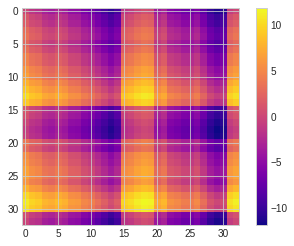

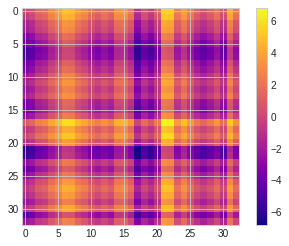

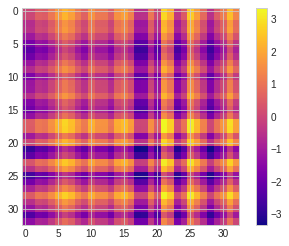

In [ ]:
x,y,z = get_map(ligand_coords)
plot_dist_mat(x,y,z)

### Split Train/Valid Sets

In [ ]:
# shuffle rows
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,compound_id,target_id,smiles,fasta,standard_value
0,CHEMBL3191969,Q07820,O=C(NN=CC=Cc1occc1)c2cc([nH]n2)c3ccc4ccccc4c3,MFGLKRNAVIGLNLYCGGAGLGAGSGGATRPGGRLLATEKEASARR...,0.710955
1,CHEMBL1795768,P14222,Nc1c(C#N)c(c2ccc(OCC(=O)NCCc3ccncc3)cc2)c(C#N)...,MAARLLLLGILLLLLPLPVPAPCHTAARSECKRSHKFVPGAWLAGE...,-0.210340
2,CHEMBL3208275,Q9BQF6,OC(=CC=Nc1cccc(c1)[N+](=O)[O-])c2occc2,MDKRKLGRRPSSSEIITEGKRKKSSSDLSEIRKMLNAKPEDVHVQS...,-0.480368
3,CHEMBL494979,P08581,COc1ccc2c(OCc3nnc4ccc(nn34)c5cc(F)c(F)c(F)c5)c...,VHFNEVIGRGHFGCVYHGTLLDNDGKKIHCAVKSLNRITDIGEVSQ...,7.613706
4,CHEMBL1684042,Q01959,CC(N)C1(CCCCC1)c2ccc(Cl)c(Cl)c2,MSKSKCSVGLMSSVVAPAKEPNAVGPKEVELILVKEQNGVQLTSST...,4.765893


In [ ]:
num_train = 500000
batch_siz = 5000
train_all = data[:num_train]
valid = data[num_train:]
del data
print('Num Training Samples:', len(train_all))
print('Num Validation Samples:', len(valid))

Num Training Samples: 500000
Num Validation Samples: 3984


In [ ]:
print("Train Proteins:", len(train_all.fasta.unique()))
print("Train Ligands:", len(train_all.smiles.unique()), "\n")

valid_proteins = len(valid.fasta.unique())
valid_ligands = len(valid.smiles.unique())
print("Valid Proteins:", valid_proteins)
print("Valid Ligands:", valid_ligands)

Train Proteins: 3837
Train Ligands: 323925 

Valid Proteins: 1125
Valid Ligands: 3958


In [ ]:
shared_proteins = len(set(train_all.fasta) & set(valid.fasta))
shared_ligands = len(set(train_all.smiles) & set(valid.smiles))
print(shared_proteins, "Proteins Shared Over Train and Valid Sets")
print(shared_ligands, "Ligands Shared Over Train and Valid Sets")

1125 Proteins Shared Over Train and Valid Sets
2210 Ligands Shared Over Train and Valid Sets


In [ ]:
print("Valid Set Contains", valid_proteins-shared_proteins, "New Proteins")
print("Valid Set Contains", valid_ligands-shared_ligands, "New Ligands")

Valid Set Contains 0 New Proteins
Valid Set Contains 1748 New Ligands


## Make Validation Data

In [ ]:
list_smiles_elements = ['6', '3', '=', 'H', 'C', 'O', 'c', '#', 'a', '[', 't', 'r', 'K', 'n', 'B', 'F', '4', '+', ']', '-', '1', 'P', '0', 'L', '%', 'g', '9', 'Z', '(', 'N', '8', 'I', '7', '5', 'l', ')', 'A', 'e', 'o', 'V', 's', 'S', '2', 'M', 'T', 'u', 'i', 'b', 'R', 'W', 'G', 'd']
smiles_to_int = dict(zip(list_smiles_elements, range(1, len(list_smiles_elements)+1)))
elements = len(list_smiles_elements) + 1 # added one for empty characters filled in with 0's

amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
amino_to_int = dict(zip(amino_acids, range(1, len(amino_acids)+1)))
aminos = len(amino_acids) + 1 # added one for empty characters filled in with 0's

In [ ]:
def pad_img(arr):
    arr = arr[:max_smiles, :max_smiles]
    return np.pad(arr, [(0, max_smiles-arr.shape[0]), (0, max_smiles-arr.shape[0])], mode='constant', constant_values=0).reshape(max_smiles, max_smiles, 1)

def get_data(data):

    smiles = []
    coord_images = []
    for seq in data.smiles:
        factorized_seq_list = []
        for element in seq:
            factorized_seq_list.append(smiles_to_int[element])
        factorized_seq_list += [0] * (max_smiles-len(factorized_seq_list)) # pad with zeros
        smiles.append(factorized_seq_list)

        ligand_coords, _ = get_coords_ligand(seq)
        x,y,z = get_map(ligand_coords)
        x,y,z = pad_img(x), pad_img(y), pad_img(z)
        coord_image = np.concatenate([x, y, z], axis=2)
        coord_images.append(coord_image)

    fastas = []
    for seq in data.fasta:
        factorized_seq_list = []
        for amino in seq.upper():
            factorized_seq_list.append(amino_to_int[amino])
        factorized_seq_list += [0] * (max_fasta-len(factorized_seq_list)) # pad with zeros
        fastas.append(factorized_seq_list)

    labels = list(data.standard_value)

    return smiles, fastas, coord_images, labels

In [ ]:
x_valid_smiles, x_valid_fasta, x_valid_coords, y_valid = get_data(valid)

print(x_valid_smiles[0])
print(x_valid_fasta[0])
print(y_valid[0])

[5, 35, 7, 21, 7, 7, 7, 43, 7, 29, 30, 30, 3, 5, 7, 2, 7, 7, 7, 7, 7, 2, 15, 12, 36, 7, 7, 14, 7, 43, 7, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[11, 1, 1, 4, 16, 10, 13, 5, 17, 10, 4, 17, 19, 16, 16, 20, 4, 10, 4, 1, 20, 22, 4, 3, 10, 14, 4, 19, 10, 16, 16, 3, 4, 8, 6, 6, 17, 22, 8, 16, 16, 13, 6, 12, 4, 4, 4, 4, 16, 9, 17, 5, 17, 17, 10, 3, 13, 1, 16, 10, 1, 20, 10, 17, 4, 4, 13, 6, 13, 17, 4, 19, 17, 15, 17, 16, 14, 16, 13, 15, 16, 13, 3, 16, 16, 14, 16, 16, 11, 1, 14, 4, 4, 4, 4, 4, 4, 14, 6, 15, 17, 15, 9, 15, 9, 14, 16, 6, 14, 2, 13, 1, 15, 13, 6, 9, 14, 15, 11, 9, 4, 9, 4, 14, 4, 12, 4, 15, 9, 19, 1, 14, 10, 1, 4, 4, 12, 4, 15, 10, 9, 14, 4, 8, 4, 15, 10, 17, 15, 4, 19, 4, 17, 17, 15, 15, 1, 10, 8, 3, 15, 11, 19, 16, 10, 7, 14, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


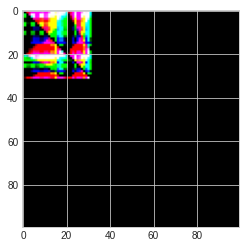

In [ ]:
plt.imshow(x_valid_coords[0])

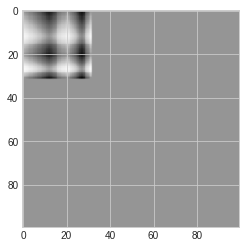

In [ ]:
plt.imshow(x_valid_coords[0][:,:,0])

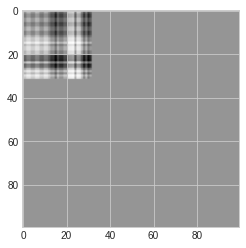

In [ ]:
plt.imshow(x_valid_coords[0][:,:,1])

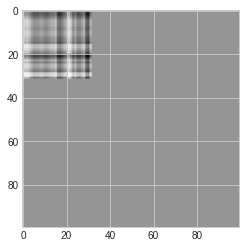

In [ ]:
plt.imshow(x_valid_coords[0][:,:,2])

## Model

In [ ]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'projection_dim': self.projection_dim,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'combine_heads': self.combine_heads,
        })
        return config

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb,
        })
        return config 

In [ ]:
embed_dim = 12 # embedding size for each token
num_heads = 4  # number of attention heads
ff_dim = 512  # hidden layer size in feed forward network inside transformer

smiles_input = tf.keras.layers.Input(shape=(max_smiles,), dtype='int32', name='smiles_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_smiles = TokenAndPositionEmbedding(max_smiles, elements, embed_dim)(smiles_input)

# use transformer blocks to extract information from the sequence
smiles_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(embed_smiles)
smiles_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(smiles_transformer)
smiles_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(smiles_transformer)

# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_smiles = tf.keras.layers.GlobalMaxPooling1D()(smiles_transformer)

fasta_input = tf.keras.layers.Input(shape=(max_fasta,), dtype='int32', name='fasta_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_fasta = tf.keras.layers.Embedding(output_dim=256, input_dim=aminos, input_length=max_fasta)(fasta_input)

# use 1-D convolutional filters to transform the vector sequence into a single vector containing information about the entire sequence
conv1_fasta = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(embed_fasta)
conv2_fasta = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(conv1_fasta)
conv3_fasta = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(conv2_fasta)
# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_fasta = tf.keras.layers.GlobalMaxPooling1D()(conv3_fasta)

coords_input = tf.keras.layers.Input(shape=(max_smiles, max_smiles, 3), dtype='float32', name='coords_input')

# use 2-D convolutional filters to transform the vector sequence into a single vector containing information about the entire sequence
conv1_coords = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(coords_input)
max_pool1_coords = tf.keras.layers.MaxPool2D(pool_size=2)(conv1_coords)
conv2_coords = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(max_pool1_coords)
max_pool2_coords = tf.keras.layers.MaxPool2D(pool_size=2)(conv2_coords)
conv3_coords = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(max_pool2_coords)
# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_coords = tf.keras.layers.GlobalMaxPooling2D()(conv3_coords)

# merge both smiles, fasta, and coords
concat_pools = tf.keras.layers.concatenate([global_pool_smiles, global_pool_fasta, global_pool_coords])

# dense layers 
dense1 = tf.keras.layers.Dense(512, activation=tf.keras.activations.swish)(concat_pools)
dropout1_dense = tf.keras.layers.Dropout(0.1)(dense1) 
dense2 = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(dropout1_dense)

# output
output = tf.keras.layers.Dense(1, name='output', activation="relu", kernel_initializer="normal")(dense2) 

model = tf.keras.models.Model(inputs=[smiles_input, fasta_input, coords_input], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
coords_input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
smiles_input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
fasta_input (InputLayer)        [(None, 5000)]       0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 896         coords_input[0][0]               
______________________________________________________________________________________________

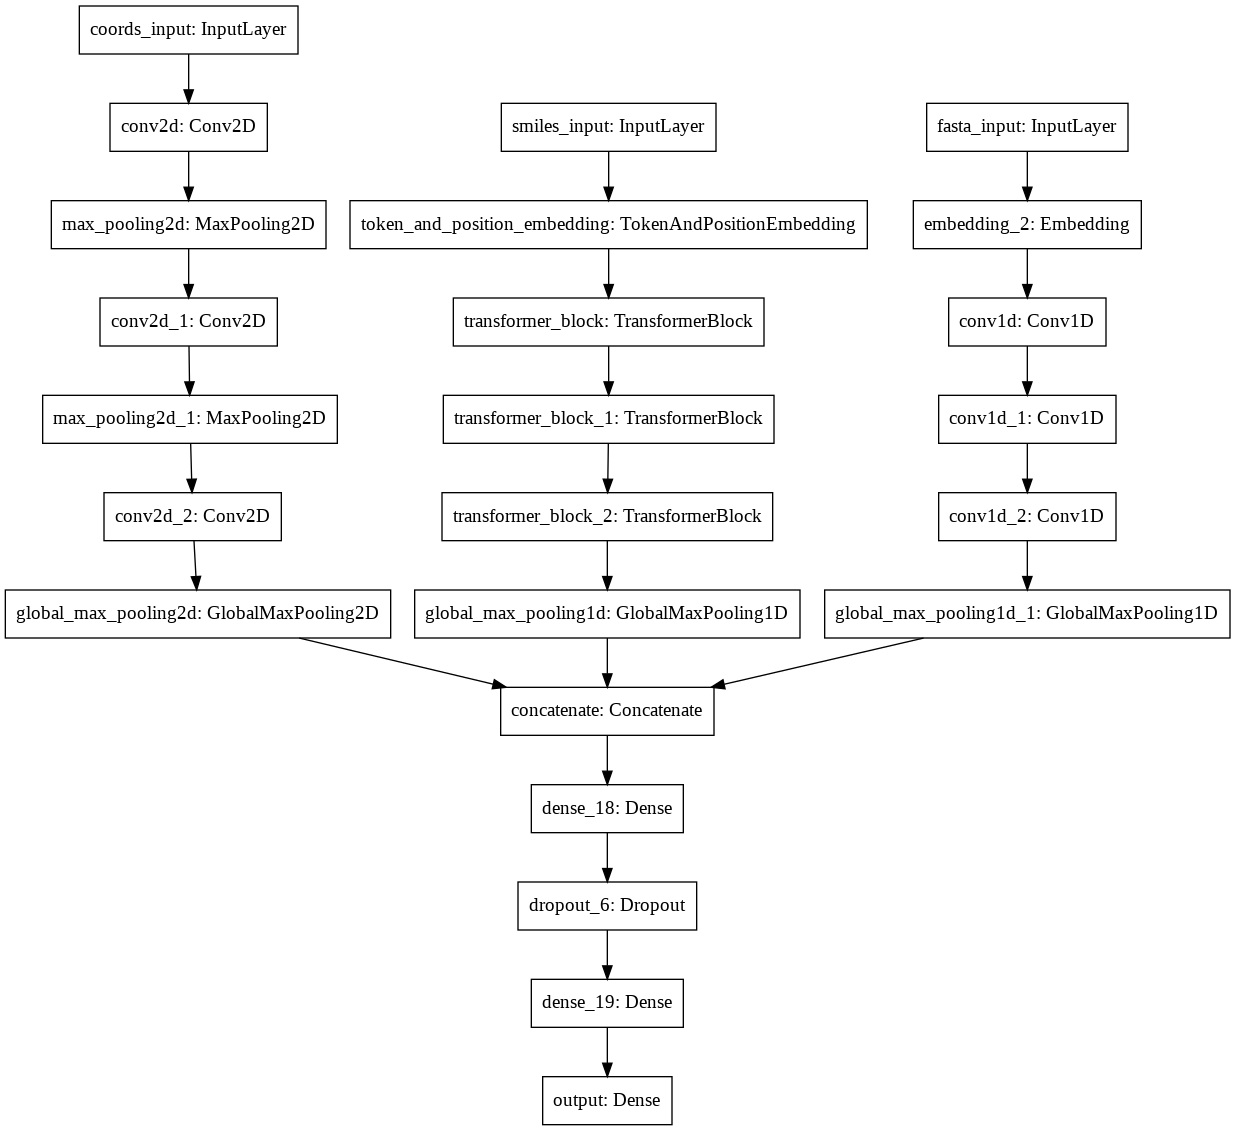

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
# loss function
def root_mean_squared_error(y_true, y_pred):
    return tf.keras.backend.sqrt(mean_squared_error(y_true, y_pred))

# accuracy metric
def r2_score(y_true, y_pred):
    SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred)) 
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true))) 
    return (1-SS_res/(SS_tot)+tf.keras.backend.epsilon())

# compile model
model.compile(optimizer = 'adam', 
              loss = {'output': 'mae'}, # 'mse', 'mae', root_mean_squared_error
              metrics = {'output': r2_score}) 

## Train

In [ ]:
# checkpointer
save_model_path = "affinity-best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(save_model_path, 
                                                monitor='val_loss', 
                                                verbose=1,        
                                                save_best_only=True)

In [ ]:
epochs = 3

for epoch in range(epochs):

    print("\nStarting Epoch", epoch+1, "\n")

    train_index_start = 0
    train_index_end = batch_siz
    while train_index_end < num_train:

        x_train_smiles, x_train_fasta, x_train_coords, y_train = get_data(train_all[train_index_start:train_index_end])

        # fit model
        model.fit({'smiles_input': np.array(x_train_smiles), 
                   'fasta_input': np.array(x_train_fasta),
                   'coords_input': np.array(x_train_coords)},
                  {'output': np.array(y_train)},
                  validation_data=({'smiles_input': np.array(x_valid_smiles), 
                                    'fasta_input': np.array(x_valid_fasta), 
                                    'coords_input': np.array(x_valid_coords)},
                  {'output': np.array(y_valid)}),
                  callbacks=[checkpoint],
                  epochs=1, 
                  batch_size=128)
        
        train_index_start += batch_siz
        train_index_end += batch_siz

In [ ]:
from google.colab import files

files.download(save_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Make Predictions

In [ ]:
model.load_weights(save_model_path)

In [ ]:
def predict_affinity(smiles, fasta):

    smiles_in = []
    for element in smiles:
        smiles_in.append(smiles_to_int[element])
    smiles_in = smiles_in[:max_smiles]
    smiles_in += [0] * (max_smiles-len(smiles_in)) 

    ligand_coords, _ = get_coords_ligand(smiles)
    x,y,z = get_map(ligand_coords)
    x,y,z = pad_img(x), pad_img(y), pad_img(z)
    coord_image = np.concatenate([x, y, z], axis=2)

    fasta_in = []
    for amino in fasta:
        fasta_in.append(amino_to_int[amino])
    fasta_in += [0] * (max_fasta-len(fasta_in)) 

    return model.predict({'smiles_input': np.array(smiles_in).reshape(1, max_smiles,), 
                          'fasta_input': np.array(fasta_in).reshape(1, max_fasta,), 
                          'coords_input': np.array(coord_image).reshape(1, max_smiles, max_smiles, 3)})[0][0]

In [ ]:
idx = 123
compound = valid.iloc[idx].smiles
protein = valid.iloc[idx].fasta
print(compound)
print(protein)
print(predict_affinity(compound, protein))
print(valid.iloc[idx].standard_value)

# Visualize Target Protein

## Coronavirus

In [ ]:
!pip3 -q install py3Dmol
import py3Dmol

id = "1q2w"

view = py3Dmol.view(query='pdb:'+id, width=1000, height=1000) 
view.setStyle({'cartoon':{'color':'spectrum'}}) 

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
view.render_image()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
!pip3 install -q prody
from prody import parsePDB, showProtein

     |████████████████████████████████| 2.3MB 5.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


@> PDB file is found in working directory (1q2w.pdb.gz).
@> 5051 atoms and 1 coordinate set(s) were parsed in 0.06s.


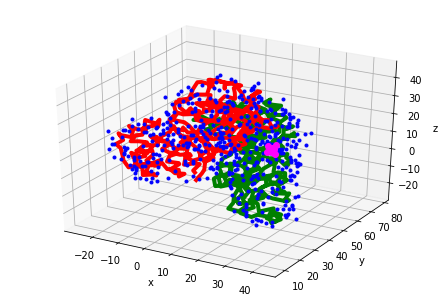

In [ ]:
protein, header = parsePDB('1q2w', header=True)
showProtein(protein, water='blue', A='green', B="red")

In [ ]:
protein_coords = protein.getCoords()
protein_atoms = protein.getNames()

In [ ]:
import plotly.express as px

px.scatter_3d(x=[i[0] for i in protein_coords], y=[i[1] for i in protein_coords], z=[i[2] for i in protein_coords], color=protein_atoms, opacity=0.75, width=1000, height=1000).show()

In [ ]:
h2o = protein.select('water')
water_coords = h2o.getCoords()

In [ ]:
x,y,z = get_map(water_coords)
plot_dist_mat(x,y,z)

In [ ]:
px.scatter_3d(x=[i[0] for i in water_coords], y=[i[1] for i in water_coords], z=[i[2] for i in water_coords], opacity=0.75, width=1000, height=1000).show()

In [ ]:
px.scatter_3d(x=[i[0] for i in protein_coords]+[i[0] for i in water_coords], y=[i[1] for i in protein_coords]+[i[1] for i in water_coords], z=[i[2] for i in protein_coords]+[i[2] for i in water_coords], color=["protein"]*len(protein_coords)+["water"]*len(water_coords), opacity=0.75, width=1000, height=1000).show()

In [ ]:
# temperature factor, B factor, B value, or Debye-Waller factor - describes the degree to which the electron density is spread out
# measured in units of Å2 - indicating the relative vibrational motion of different parts of the structure - atoms with low B-factors belong to a part of the structure that is well ordered

protein_betas = []
for chain in protein.getHierView().iterChains():
    protein_betas += list(protein.getHierView()[str(chain)[-1]].getBetas())

water_betas = h2o.getBetas()

In [ ]:
px.scatter_3d(x=[i[0] for i in protein_coords], y=[i[1] for i in protein_coords], z=[i[2] for i in protein_coords], color=protein_betas, opacity=0.75, width=1000, height=1000).show()

In [ ]:
px.scatter_3d(x=[i[0] for i in water_coords], y=[i[1] for i in water_coords], z=[i[2] for i in water_coords], color=water_betas, opacity=0.75, width=1000, height=1000).show()

In [ ]:
from prody import ANM, calcMechStiff, showMechStiff, showMeanMechStiff, showPairDeformationDist

calphas = protein.ca
anm = ANM('GFP ANM analysis')
anm.buildHessian(calphas, cutoff=13.0)
anm.calcModes(n_modes='all')
stiffness = calcMechStiff(anm, calphas)

@> Hessian was built in 0.24s.
@> 1770 modes were calculated in 1.92s.
@> Calculating stiffness matrix.
@> Stiffness matrix calculated in 2.47s.
@> The range of effective force constant is: 3.938498879775721 to 18.99800075485221.


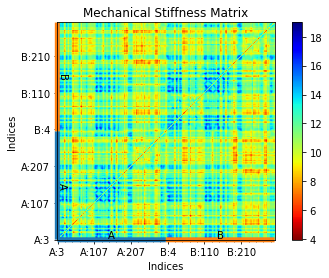

In [ ]:
show = showMechStiff(stiffness, calphas)

# PharmaceuticAI

## Imports and Installations

In [ ]:
# install conda on google colab
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-03-11 23:31:05--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   230MB/s    in 0.4s    

2021-03-11 23:31:06 (230 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

In [ ]:
!conda install -q -c rdkit rdkit -y # for molecule analysis and visualization

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps

# suppress rdkit error/warning messages
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.warning')

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2021.1.19  |       h06a4308_1         118 KB
    cairo-1.16.0               |       hf32fb01_1         1.0 MB
    certifi-2020.12.5          |   py37h06a4308_0         141 KB
    conda-4.9.2                |   py37h06a4308_0         2.9 MB
    fontconfig-2.13.1          |       h6c09931_0         250 KB
    freetype-2.10.4            |       h5ab3b9f_0         596 KB
    glib-2.67.4                |       h36276a3_1         3.0 MB
    icu-58.2                   |       he6710b0_3        10.5 MB
    intel-openmp-2020.2        |              254         786 KB
    j

In [ ]:
!pip3 install -q chembl_webresource_client # https://www.ebi.ac.uk/chembl/

from chembl_webresource_client.new_client import new_client

     |████████████████████████████████| 61kB 6.6MB/s 


In [ ]:
import numpy as np
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Thu Mar  4 21:59:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Parse Data

In [ ]:
# double letters for one element turned into single letters that are not in the dataset
double_to_single = {'Si':'q', 'Se':'w', 'Cn':'t', 'Sc':'y', 'Cl':'u', 'Sn':'z', 'Br':'x'} 
single_to_double = {'q':'Si', 'w':'Se', 't':'Cn', 'y':'Sc', 'u':'Cl', 'z':'Sn', 'x':'Br'}
elements_with_double_letters = list(double_to_single)

In [ ]:
element_set = ['C', '(', '=', 'O', ')', 'N', 'c', '1', '$', '2', '3', '4', '#', 'n', 'F', 'u', '-', '[', 'H', ']', 's', 'o', 'S', 't', '5', '6', '+', 'P', 'I', 'x', 'y', 'q', 'B', 'w', '7', '8', 'e', '9', 'b', 'p', '%', '0', 'z']
n_vocab = len(element_set)
element_to_int = dict(zip(element_set, range(0, n_vocab)))
int_to_element = {v: k for k, v in element_to_int.items()}
sequence_length = 100 

In [ ]:
filey = open('pharmaceuticAI_all_compounds.smiles')
structures = [line[:-1] for line in filey]
print("Num Total Samples:", len(structures))
filey.close()

num_sampled = 75000
np.random.shuffle(structures)
data = structures[:num_sampled]
del structures
print("Num Sampled:", num_sampled)

In [ ]:
def gen_structs(data):

    structs = []
    for structure in data:
        i = 0
        while i < len(structure):
            try:
                if structure[i] + structure[i+1] in elements_with_double_letters:
                    structs.append(double_to_single[structure[i] + structure[i+1]])
                    i+=2
                else:
                    structs.append(structure[i])
                    i+=1
            except:
                    structs.append(structure[i])
                    i+=1
        structs.append("$") # end token

    return structs

def gen_data(structs):

    network_inp = []

    # create input sequences
    for i in range(0, len(structs) - sequence_length):
        sequence_in = structs[i:i + sequence_length]
        network_inp.append([element_to_int[char] for char in sequence_in])
        
    n_patterns = len(network_inp)

    # reshape the input into a format compatible with CuDNNLSTM layers
    network_inp = np.reshape(network_inp, (n_patterns, sequence_length))

    return network_inp

network_input = gen_data(gen_structs(data))

In [ ]:
max_smiles = 100
max_fasta = 5000

list_smiles_elements = ['6', '3', '=', 'H', 'C', 'O', 'c', '#', 'a', '[', 't', 'r', 'K', 'n', 'B', 'F', '4', '+', ']', '-', '1', 'P', '0', 'L', '%', 'g', '9', 'Z', '(', 'N', '8', 'I', '7', '5', 'l', ')', 'A', 'e', 'o', 'V', 's', 'S', '2', 'M', 'T', 'u', 'i', 'b', 'R', 'W', 'G', 'd']
smiles_to_int = dict(zip(list_smiles_elements, range(1, len(list_smiles_elements)+1)))
elements = len(list_smiles_elements) + 1 # added one for empty characters filled in with 0's

amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'] 
amino_to_int = dict(zip(amino_acids, range(1, len(amino_acids)+1)))
aminos = len(amino_acids) + 1 # added one for empty characters filled in with 0's

In [ ]:
smiles_input = tf.keras.layers.Input(shape=(sequence_length,), dtype='int32', name='smiles_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_smiles = tf.keras.layers.Embedding(output_dim=12, input_dim=n_vocab, input_length=sequence_length)(smiles_input) 

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
lstm_smiles1 = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer='normal', bias_initializer='zeros')(embed_smiles)
lstm_smiles2 = tf.compat.v1.keras.layers.CuDNNLSTM(512, return_sequences=True, kernel_initializer='normal', bias_initializer='zeros')(lstm_smiles1)
lstm_smiles3 = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer='normal', bias_initializer='zeros')(lstm_smiles2)

# turn into vector
vec = tf.keras.layers.Flatten()(lstm_smiles3)
dropout_vec = tf.keras.layers.AlphaDropout(0.1)(vec)

# dense layers 
dense1 = tf.keras.layers.Dense(256, activation=tf.keras.activations.swish)(dropout_vec)
dropout1_dense = tf.keras.layers.AlphaDropout(0.1)(dense1)
dense2 = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(dropout1_dense)

# output
output = tf.keras.layers.Dense(n_vocab, activation="softmax", name='output')(dense2) 

model = tf.keras.models.Model(inputs=smiles_input, outputs=[output])

model.summary()

# load best model
model.load_weights("SMILES-best.hdf5")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
smiles_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 12)           516       
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 100, 256)          276480    
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 512)          1576960   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100, 256)          788480

In [ ]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'projection_dim': self.projection_dim,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'combine_heads': self.combine_heads,
        })
        return config

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb,
        })
        return config 

In [ ]:
embed_dim = 12 # embedding size for each token
num_heads = 4  # number of attention heads
ff_dim = 512  # hidden layer size in feed forward network inside transformer

smiles_input = tf.keras.layers.Input(shape=(max_smiles,), dtype='int32', name='smiles_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_smiles = TokenAndPositionEmbedding(max_smiles, elements, embed_dim)(smiles_input)

# use transformer blocks to extract information from the sequence
smiles_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(embed_smiles)
smiles_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(smiles_transformer)
smiles_transformer = TransformerBlock(embed_dim, num_heads, ff_dim)(smiles_transformer)

# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_smiles = tf.keras.layers.GlobalMaxPooling1D()(smiles_transformer)

fasta_input = tf.keras.layers.Input(shape=(max_fasta,), dtype='int32', name='fasta_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_fasta = tf.keras.layers.Embedding(output_dim=256, input_dim=aminos, input_length=max_fasta)(fasta_input)

# use 1-D convolutional filters to transform the vector sequence into a single vector containing information about the entire sequence
conv1_fasta = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(embed_fasta)
conv2_fasta = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(conv1_fasta)
conv3_fasta = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(conv2_fasta)
# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_fasta = tf.keras.layers.GlobalMaxPooling1D()(conv3_fasta)

coords_input = tf.keras.layers.Input(shape=(max_smiles, max_smiles, 3), dtype='float32', name='coords_input')

# use 2-D convolutional filters to transform the vector sequence into a single vector containing information about the entire sequence
conv1_coords = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(coords_input)
max_pool1_coords = tf.keras.layers.MaxPool2D(pool_size=2)(conv1_coords)
conv2_coords = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(max_pool1_coords)
max_pool2_coords = tf.keras.layers.MaxPool2D(pool_size=2)(conv2_coords)
conv3_coords = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME', activation=tf.keras.activations.swish)(max_pool2_coords)
# create vector for dense layers by applying pooling on the spatial dimensions until each spatial dimension is one 
global_pool_coords = tf.keras.layers.GlobalMaxPooling2D()(conv3_coords)

# merge both smiles, fasta, and coords
concat_pools = tf.keras.layers.concatenate([global_pool_smiles, global_pool_fasta, global_pool_coords])

# dense layers 
dense1 = tf.keras.layers.Dense(512, activation=tf.keras.activations.swish)(concat_pools)
dropout1_dense = tf.keras.layers.Dropout(0.1)(dense1) 
dense2 = tf.keras.layers.Dense(64, activation=tf.keras.activations.swish)(dropout1_dense)

# output
output = tf.keras.layers.Dense(1, name='output', activation="relu", kernel_initializer="normal")(dense2) 

affinity_model = tf.keras.models.Model(inputs=[smiles_input, fasta_input, coords_input], outputs=[output])

affinity_model.summary()

affinity_model.load_weights("affinity-best.hdf5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
coords_input (InputLayer)       [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
smiles_input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
fasta_input (InputLayer)        [(None, 5000)]       0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 896         coords_input[0][0]               
______________________________________________________________________________________________

In [ ]:
def get_coords_ligand(smiles):

    try:
        m = Chem.MolFromSmiles(smiles)
        m = Chem.AddHs(m)
        AllChem.EmbedMolecule(m)
        AllChem.UFFOptimizeMolecule(m, maxIters=200)

        ligand_coords = []
        ligand_atoms = []
        for atom in Chem.MolToMolBlock(m).split("\n")[4:4+len(m.GetAtoms())]:
            atom = atom.split()
            x = atom[0]
            y = atom[1]
            z = atom[2]
            ligand_coords.append([x,y,z])
            ligand_atoms.append(atom[3])

    except KeyboardInterrupt:
        pass

    except:
        ligand_coords = [[0, 0, 0]]
        ligand_atoms = ["none"]
    
    return ligand_coords, ligand_atoms

def get_map(coords):

    coords = np.array(coords, dtype="float32")

    x_map = []
    y_map = []
    z_map = []
    for coord1 in coords:
        x_dists = []
        y_dists = []
        z_dists = []
        for coord2 in coords:
            x_dists.append(coord1[0] - coord2[0])
            y_dists.append(coord1[1] - coord2[1])
            z_dists.append(coord1[2] - coord2[2])
        x_map.append(x_dists)
        y_map.append(y_dists)
        z_map.append(z_dists)

    return np.array(x_map, dtype="float32"), np.array(y_map, dtype="float32"), np.array(z_map, dtype="float32")

def pad_img(arr):
    arr = arr[:max_smiles, :max_smiles]
    return np.pad(arr, [(0, max_smiles-arr.shape[0]), (0, max_smiles-arr.shape[0])], mode='constant', constant_values=0).reshape(max_smiles, max_smiles, 1)

def get_data(data):

    smiles = []
    coord_images = []
    for seq in data.smiles:
        factorized_seq_list = []
        for element in seq:
            factorized_seq_list.append(smiles_to_int[element])
        factorized_seq_list += [0] * (max_smiles-len(factorized_seq_list)) # pad with zeros
        smiles.append(factorized_seq_list)

        ligand_coords, _ = get_coords_ligand(seq)
        x,y,z = get_map(ligand_coords)
        x,y,z = pad_img(x), pad_img(y), pad_img(z)
        coord_image = np.concatenate([x, y, z], axis=2)
        coord_images.append(coord_image)

    fastas = []
    for seq in data.fasta:
        factorized_seq_list = []
        for amino in seq.upper():
            factorized_seq_list.append(amino_to_int[amino])
        factorized_seq_list += [0] * (max_fasta-len(factorized_seq_list)) # pad with zeros
        fastas.append(factorized_seq_list)

    labels = list(data.standard_value)

    return smiles, fastas, coord_images, labels

def predict_affinity(list_of_smiles, fasta):

    list_of_smiles = [i for i in list_of_smiles if i != None] # remove None objects

    fasta = fasta[:max_fasta] # truncate fasta sequence if it is longer than the maximum sequence length

    # create fasta sequence input
    fasta_in = []
    for amino in fasta:
        fasta_in.append(amino_to_int[amino])
    fasta_in += [0] * (max_fasta-len(fasta_in)) 

    all_pred = []
    for molecule in list_of_smiles:

        molecule = molecule.replace('p',"P") # "p" is not in the list of elements the affinity model was trained on, but "P" is, which is the same elements but not in SMILES syntax
                                             # rules on lowercase: upper case letters refer to non-aromatic atoms; lower case letters refer to aromatic atoms - if the atomic symbol has more than one letter, the second letter must be lower case
        molecule = molecule.replace('/', "").replace('@', "").replace('\\', "").replace('.', "") # affinity data does not include these symbols

        molecule = molecule[:max_smiles] # truncate molecules smiles sequence if it is longer than the maximum sequence length

        # create smiles sequence input
        smiles_in = []
        for element in molecule:
            smiles_in.append(smiles_to_int[element])
        smiles_in = smiles_in[:max_smiles] 
        smiles_in += [0] * (max_smiles-len(smiles_in))

        ligand_coords, _ = get_coords_ligand(molecule)
        x,y,z = get_map(ligand_coords)
        x,y,z = pad_img(x), pad_img(y), pad_img(z)
        coord_image = np.concatenate([x, y, z], axis=2)

        pred = affinity_model.predict({'smiles_input': np.array(smiles_in).reshape(1, max_smiles,), 
                                       'fasta_input': np.array(fasta_in).reshape(1, max_fasta,), 
                                       'coords_input': np.array(coord_image).reshape(1, max_smiles, max_smiles, 3)})[0][0] # make prediction
        all_pred.append(pred)
      
    return all_pred

## Molecule Analysis

In [ ]:
melatonin = "COC1=CC2=C(NC=C2CCNC(C)=O)C=C1"
glycogen = "C(C1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3C(OC(C(C3O)O)O)CO)O)O)OC4C(C(C(C(O4)CO)O)O)O)O)O)O)O"
penicillin = "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C" 

In [ ]:
def test_molecule(molecule):
    if molecule == None or len(molecule) <= 3:
        return False
    mol = Chem.MolFromSmiles(molecule)
    if mol == None:
        return False
    else:
        try:
            Chem.Draw.MolToImage(mol) # if molecule is not drawable, the molecule is not valid
            return True
        except:
            return False
      
print(test_molecule(penicillin))
print(test_molecule("abc123"))

True
False


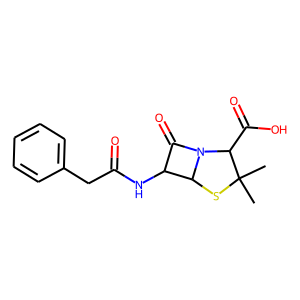

In [ ]:
def draw_compound(molecule):
    m = Chem.MolFromSmiles(molecule)
    weight = Chem.Descriptors.MolWt(m)
    return Chem.Draw.MolToImage(m)
  
draw_compound(penicillin) 

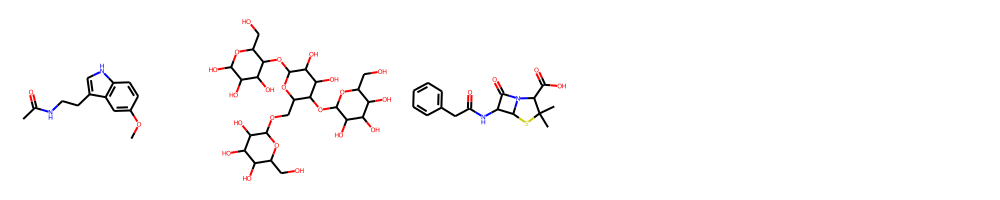

In [ ]:
def draw_list_compounds(molecules):
  list_molecules = []
  for i in molecules:
     list_molecules.append(Chem.MolFromSmiles(i))
  return Chem.Draw.MolsToGridImage(list_molecules, molsPerRow=5)

draw_list_compounds([melatonin, glycogen, penicillin])

In [ ]:
def analyze_compound(molecule):
  m = Chem.MolFromSmiles(molecule)
  print("Molecule Weight:", Chem.Descriptors.MolWt(m), "g/mol")
  print("Num Atoms:", m.GetNumAtoms())
  print("LogP:", Chem.Descriptors.MolLogP(m))
  print("TPSA:", Chem.Descriptors.TPSA(m))

analyze_compound(penicillin)

Molecule Weight: 334.39700000000005 g/mol
Num Atoms: 23
LogP: 0.8607999999999993
TPSA: 86.71000000000001


In [ ]:
def get_h_bond_donors(mol): # returns the number of hydrogen bond donors (NH and OH)
    idx = 0
    donors = 0
    while idx < len(mol)-1:
        if mol[idx].lower() == "o" or mol[idx].lower() == "n":
            if mol[idx+1].lower() == "h":
                donors+=1
        idx+=1
    return donors

def get_h_bond_acceptors(mol): # returns the number of hydrogen bond acceptors (N and O)
    acceptors = 0
    for i in mol:
        if i.lower() == "n" or i.lower() == "o":
            acceptors+=1
    return acceptors

# Lipinski's “Rule of Five” - Constraints in order to maintain drug-like character within the compounds
def rule_of_five(molecule):
    m = Chem.MolFromSmiles(molecule)
    if get_h_bond_donors(molecule) <= 5 and get_h_bond_acceptors(molecule) <= 10 and Chem.Descriptors.MolWt(m) <= 500 and Chem.Descriptors.MolLogP(m) <= 5: # constraints
        return True
    else:
        return False

print(rule_of_five(melatonin))
print(rule_of_five(glycogen)) # not a drug - should be False
print(rule_of_five(penicillin))

True
False
True


In [ ]:
def similarity(molecule1, molecule2): # fraction of fingerprints the set of two molecules have in common
    m1 = Chem.MolFromSmiles(molecule1)
    bi1 = {}
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, radius=2, nBits=2048, bitInfo=bi1)
    fp1_bits1 = fp1.GetOnBits()

    m2 = Chem.MolFromSmiles(molecule2)
    bi2 = {}
    fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, radius=2, nBits=2048, bitInfo=bi2)
    fp2_bits2 = fp2.GetOnBits()

    common = set(fp1_bits1) & set(fp2_bits2)
    combined = set(fp1_bits1) | set(fp2_bits2)

    return len(common)/len(combined) # recreation of DataStructs.TanimotoSimilarity

similarity(melatonin, penicillin)

0.1388888888888889

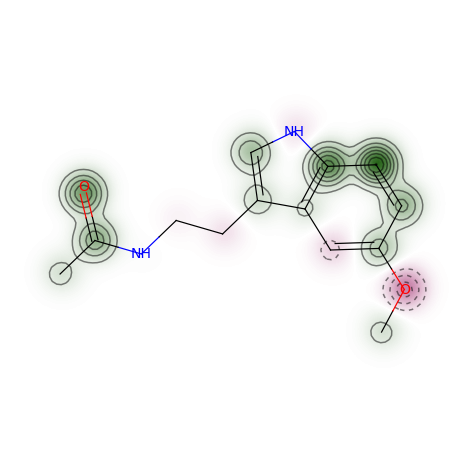

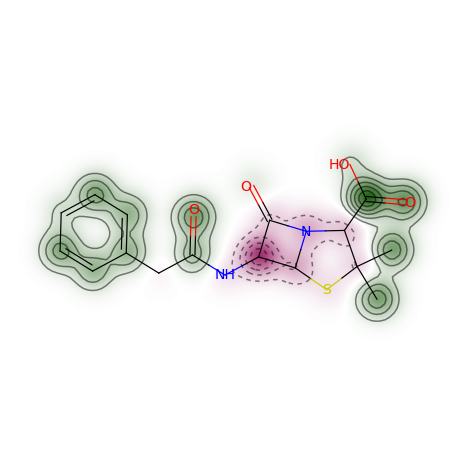

In [ ]:
def similarity_map(molecule1, molecule2):

    m1 = Chem.MolFromSmiles(molecule1)
    m2 = Chem.MolFromSmiles(molecule2)

    fig1, maxweight1 = Chem.Draw.SimilarityMaps.GetSimilarityMapForFingerprint(m2, m1, Chem.Draw.SimilarityMaps.GetMorganFingerprint)
    fig2, maxweight2 = Chem.Draw.SimilarityMaps.GetSimilarityMapForFingerprint(m1, m2, Chem.Draw.SimilarityMaps.GetMorganFingerprint)

similarity_map(melatonin, penicillin)

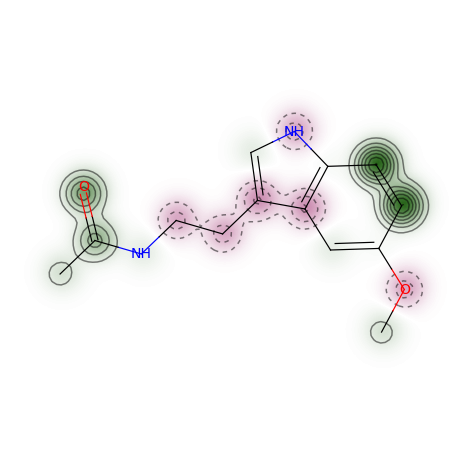

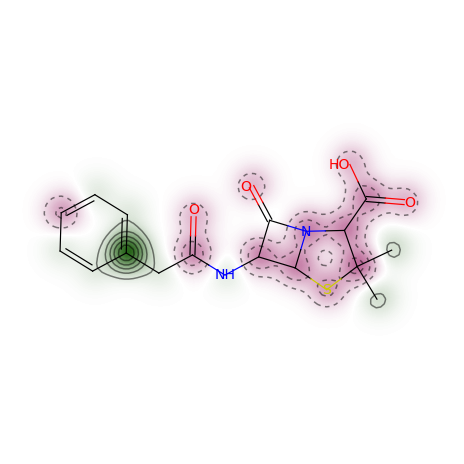

In [ ]:
def similarity_map_tanimoto(molecule1, molecule2, r):

    m1 = Chem.MolFromSmiles(molecule1)
    m2 = Chem.MolFromSmiles(molecule2)

    fig3, maxweight3 = Chem.Draw.SimilarityMaps.GetSimilarityMapForFingerprint(m2, m1, lambda m,idx: Chem.Draw.SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=r, fpType='count'), metric=DataStructs.TanimotoSimilarity)
    fig4, maxweight4 = Chem.Draw.SimilarityMaps.GetSimilarityMapForFingerprint(m1, m2, lambda m,idx: Chem.Draw.SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=r, fpType='count'), metric=DataStructs.TanimotoSimilarity)

similarity_map_tanimoto(melatonin, penicillin, 1)

## Generation Methods

In [ ]:
def generate(num_molecules=100):

    new_molecules = []

    while len(new_molecules) != num_molecules: # repeat until num_molecules molecules are generated

        start = np.random.randint(0, len(network_input)-1)
        pattern = network_input[start] # grab a random sequence

        prediction_output = []

        try:
            start_idx = len(list(pattern)) - list(pattern)[::-1].index(element_to_int["$"]) - 1 # get index of last "$" (end token) which is the start of the incomplete molecule built upon
        except:
            start_idx = 0 # in case input does not even have an end token and is just one long molecule
        start_mol = list(pattern)[start_idx+1:]
        for element in start_mol:
            prediction_output.append(int_to_element[element]) # add incomplete molecule to start of output

        # build upon the incomplete molecule with predictions (predicting the next element of the sequence)
        # will stop at 100 predictions or until the end token "$" is predicted
        for element_index in range(100):
            prediction_input = np.reshape(pattern, (1, len(pattern)))
            prediction_input = prediction_input
            prediction = model.predict(prediction_input, verbose=0)
            #index = np.argmax(prediction)
            index = np.random.choice(list(range(len(prediction[0]))), p=prediction[0])
            result = int_to_element[index]
            if result == "$":
                break
            prediction_output.append(result)
            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]

        output = "".join(prediction_output)

        for word, initial in single_to_double.items(): 
            output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements   

        if output not in new_molecules and test_molecule(output) and rule_of_five(output): # make sure that the molecules are unique, valid, and drug-like
              print("generated (randomly)", output)
              new_molecules.append(output)

    return new_molecules

In [ ]:
eos_at_end = [i for i in network_input if int_to_element[i[-1]] == "$"]

def complete_molecule(inp):

    for word, initial in double_to_single.items(): 
        inp = inp.replace(word, initial) # replace double-letter elements to single-letter for model input

    net_inp = []

    for i in range(0, len(inp)):
        seq_in = inp[i]
        net_inp.append([element_to_int[char] for char in seq_in])

    sample = eos_at_end[np.random.randint(0, len(eos_at_end))][len(inp):sequence_length]

    net_in = []
    for i in sample:
      net_in.append(i)
    for j in net_inp:
      net_in.append(j[0])

    net_input = np.reshape(net_in[-sequence_length:], (1, sequence_length))[0]

    pred_out = []
    for element_index in range(100):
        net_input = np.reshape(net_in[-sequence_length:], (1, sequence_length))
        prediction = model.predict(net_input, verbose=0)
        #index = np.argmax(prediction)
        index = np.random.choice(list(range(len(prediction[0]))), p=prediction[0])
        result = int_to_element[index]
        pred_out.append(result)
        net_input = np.append(net_input, index)
        net_input = net_input[1:len(net_input)]

    output = "".join(pred_out)

    for word, initial in single_to_double.items(): 
        output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements

    end_molecule = ""
    for i in range(0, len(output)):
        if output[i] == "$":
          end_molecule = output[:i]
          break

    molecule = inp + end_molecule
    return molecule

def generate_methodical(target_inhibitors_list): 

    target_inhibitors = [inhibitor.replace("/", "").replace("@", "").replace("\\", "").replace(".", "") for inhibitor in target_inhibitors_list]

    inhibitors_sequences = []
    for mol in target_inhibitors:
        for cutoff in range(1, len(mol)): 
            inhibitors_sequences.append(mol[:cutoff])

    new_molecules = []
    for seq in inhibitors_sequences:
        new_mol = complete_molecule(seq)
        print(new_mol)
        if new_mol not in new_molecules: # make sure that the molecules are unique
          if test_molecule(new_mol) and rule_of_five(new_mol): # make sure that the molecules are valid and drug-like
              new_molecules.append(new_molecules.append(new_mol))
              print("generated (methodically)", new_mol)

    return new_molecules

In [ ]:
def complete(inp): # helper method for augment - returns a prediction in place of the removed element

    for word, initial in double_to_single.items(): 
        inp = inp.replace(word, initial) # replace double-letter elements to single-letter for model input

    net_inp = []

    for i in range(0, len(inp)):
        seq_in = inp[i]
        net_inp.append([element_to_int[char] for char in seq_in])

    pattern = eos_at_end[np.random.randint(0, len(eos_at_end))][len(inp):sequence_length]

    net_in = []
    for i in pattern[len(inp):sequence_length]:
      net_in.append(i)
    for j in net_inp:
      net_in.append(j[0])

    net_in = np.reshape(net_in[-sequence_length:], (1, sequence_length)) 

    prediction = model.predict(net_in, verbose=0) # make prediction
    #index = np.argmax(prediction)
    index = np.random.choice(list(range(len(prediction[0]))), p=prediction[0])
    result = int_to_element[index]

    return result

def augment(compound, num_changes): # could enhance the pharmacokinetics and bioactivity of the compound

    for word, initial in double_to_single.items(): 
        compound = compound.replace(word, initial) # replace double-letter elements to single-letter for model input

    changes = np.random.randint(1, num_changes+1)
    for i in range(0, changes): # randomly removes certain amount of random elements in SMILES string compound and replaces them with prediction
        ind = np.random.randint(0, len(compound))
        changed = compound[ind]
        new_compound = compound[:ind]
        
        result = complete(new_compound)
        if result == "$":
            return compound[:ind] # if an end token is predicted, return the part of the compound up to the changed index
        else:
            compound = compound[:ind] + result + compound[ind+1:] # add the prediction in place of the removed element

    return compound # return the augmented compound after all the changes have been made

def augment_repeat(inp, sim, max_change, max_try):

  if len(inp) > sequence_length:
      inp = inp[:sequence_length]

  tries = 0
  while tries < max_try: # keep trying to make augmented molecules until the model has exceeded the max number of tries (max_try)

      augmented = augment(inp, max_change)
      tries += 1 
      for word, initial in single_to_double.items(): 
        augmented = augmented.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements
      try:
          if test_molecule(augmented) and augmented != inp and rule_of_five(augmented): # make sure that the molecules are valid and drug-like
              s = similarity(inp, augmented) # calculate similarity between the original molecule and the augmented molecule
              if s > sim and s < 1.0: # make sure the molecule follows the similarity threshold
                  print("augmented", inp, "-->", augmented, "with similarity", s)
                  return augmented
      except:
          continue

  print("could not augment", inp, "within", tries, "tries")

def aug_list(inp_list, similarity_score=0.2, max_changes=20, max_tries=100):

    molecules = [augment_repeat(compound.replace('/', "").replace('@', "").replace('\\', "").replace('.', ""), similarity_score, max_changes, max_tries) for compound in inp_list]
    molecules = list(set(molecules)) # remove duplicates
    molecules = [i for i in molecules if i] 
    return molecules

## Create Drugs

In [ ]:
import pandas as pd

def PharmaceuticAI():

    print("welcome to PharmaceuticAI")
    print("what would you like to search for? \n")

    search = str(input())

    target = new_client.target # gets all target information from ChEMBL database
    target_query = target.search(search) # search for disease, virus, etc.
    targets = pd.DataFrame.from_dict(target_query) # turn data into pandas dataframe
    if len(targets) == 0:
        print("\nno search results")
        return
    
    name_to_id = dict(zip(targets.pref_name, targets.target_chembl_id)) # dictionary linking target names to their respective ChEMBL ID
    names = []
    seqs = []
    for name in name_to_id:
        try:
            seqs.append(new_client.target_component.get(new_client.target.get(name_to_id[name])["target_components"][0]["component_id"])["sequence"]) # make sure protein sequence is obtainable
            names.append(name)
        except:
            continue 
    print("\nchoose a target\n")
    print(names, "\n") # target protein names

    target_protein = str(input())
    if target_protein not in names:
        print("\ntarget not in list")
        return

    selected_target = name_to_id[target_protein] # get ChEMBL ID of the selected target
    target_fasta = new_client.target_component.get(new_client.target.get(selected_target)["target_components"][0]["component_id"])["sequence"] # get the protein sequence fasta of the target protein

    print("\nprotein sequence for target", target_protein+":", target_fasta)
    print("length of protein sequence:", len(target_fasta))

    activity = new_client.activity # get all protein-ligand data

    print("\nwould you like to make sure all the compounds are inhibitory? this may reduce the number of compounds outputted as some compounds are inhibitory but may have a different standard type? (yes/no) \n")
    answer = str(input())
    if answer == "yes":
        res = activity.filter(target_chembl_id=selected_target).filter(standard_type="Inhibition") # filter data strictly to inhibitors of the selected target protein
    elif answer == "no":
        res = activity.filter(target_chembl_id=selected_target) # filter data to all ligands capable of interacting with the selected target protein
    else:
        print("\nit was a yes or no question!")
        return

    df = pd.DataFrame.from_dict(res) # turn data into pandas dataframe

    mols = []

    if len(df) == 0: # if no existing inhibitors are found, generate many random molecules, pick the best ones, and iterate off of them

        print("\nno existing inhibitors found")

        print("\nhow many iterations would you like to make? (integer > 0) \n")
        iterations = str(input())
        try:
            iterations = int(iterations)
            if iterations <= 0:
                print("\nhas to be an integer > 0")
                return
        except:
            print("\nhas to be > 0")
            return
        
        print("\ngenerating random molecules...")
        mols += generate(2500) # generate random molecules
        mols = list(set(mols)) # remove duplicates

        affinities = predict_affinity(mols, target_fasta) # predict the affinities of the random molecules
        molecules_and_affinities = dict(zip(mols, affinities)) # make a dictionary of the molecules and their respective affinities
        sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=True) # sort molecules
        sorted_affinities = sorted(affinities, reverse=True) # sort affinities
        for mol, aff in zip(sorted_molecules, sorted_affinities): # print the sorted molecules and their affinities
            print("molecule:", mol, "pIC50:", aff)

        molecules = sorted_molecules[:100] # take the best n molecules and use them to iterate off of
        for iter in range(iterations):

            print("\nstarting iteration", iter+1)

            mols += aug_list(molecules, similarity_score=0.1, max_changes=20, max_tries=100) # iterate off of the best molecules
            mols += generate_methodical(molecules) # iterate off of the best molecules
            mols += generate(500) # generate many random molecules as well in case they somehow perform decently
            mols = list(set(mols)) # remove duplicates

            affinities = predict_affinity(mols, target_fasta) # predict the affinities of the new molecules
            molecules_and_affinities = dict(zip(mols, affinities)) # make a dictionary of the molecules and their respective affinities
            sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=True) # sort molecules
            sorted_affinities = sorted(affinities, reverse=True) # sort affinities
            for mol, aff in zip(sorted_molecules[::-1], sorted_affinities[::-1]): # print sorted best molecules and their affinities
                print("molecule:", mol, "pIC50:", aff)

            molecules = sorted_molecules[:50] # take the best n molecules and use them in the next iteration

    else: # otherwise use the existing inhibitors (as well as generate some random compounds) to generate new molecules, pick the best ones, and iterate off of them

        target_inhibit_list = df.canonical_smiles # get all inhibitors of the target protein in SMILES format
        target_inhibit_list = list(set(target_inhibit_list)) # remove duplicates

        print("\n"+str(len(target_inhibit_list)), "existing inhibitors found with the following descriptions:")
        print(df.assay_description.unique())
        
        print("\ninhibitors:", list(target_inhibit_list))

        print("\nhow many iterations would you like to make? (integer > 0) \n")
        iterations = str(input())
        try:
            iterations = int(iterations)
            if iterations <= 0:
                print("\nhas to be an integer > 0")
                return
        except:
            print("\nhas to be > 0")
            return

        molecules = target_inhibit_list
        for iter in range(iterations):

            print("\nstarting iteration", iter+1)

            mols += aug_list(molecules, similarity_score=0.1, max_changes=20, max_tries=100) # iterate off of the existing inhibitors, and the best molecules in later iterations
            mols += generate_methodical(molecules) # iterate off of the existing inhibitors, and the best molecules in later iterations
            mols += generate(500) # generate many random molecules as well in case they somehow perform decently 
            mols = list(set(mols)) # remove duplicates

            affinities = predict_affinity(mols, target_fasta) # predict the affinities of the new molecules
            molecules_and_affinities = dict(zip(mols, affinities)) # make a dictionary of the molecules and their respective affinities
            sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=True) # sort molecules
            sorted_affinities = sorted(affinities, reverse=True) # sort affinities
            for mol, aff in zip(sorted_molecules[::-1], sorted_affinities[::-1]): # print the sorted molecules and their affinities
                print("molecule:", mol, "pIC50:", aff)

            molecules = sorted_molecules[:50] # take the best n molecules and use them in the next iteration

    mols = list(set(mols)) # in case of duplicates
    mols = [m for m in mols if m not in target_inhibit_list] # in case existing inhibitors are in the list of generated molecules
    affinities = predict_affinity(mols, target_fasta) # predict the affinities of the molecules
    molecules_and_affinities = dict(zip(mols, affinities)) # make a dictionary of the molecules and their respective affinities
    sorted_molecules = sorted(molecules_and_affinities, key=molecules_and_affinities.get, reverse=True) # sort molecules
    sorted_affinities = sorted(affinities, reverse=True) # sort affinities

    all_mols = pd.DataFrame({"molecule":sorted_molecules, "pIC50":sorted_affinities}).reset_index(drop=True)

    return all_mols

In [ ]:
generated = PharmaceuticAI()

welcome to PharmaceuticAI
what would you like to search for? 

coronavirus

choose a target

['SARS coronavirus 3C-like proteinase', 'Replicase polyprotein 1ab'] 

SARS coronavirus 3C-like proteinase

protein sequence for target SARS coronavirus 3C-like proteinase: MESLVLGVNEKTHVQLSLPVLQVRDVLVRGFGDSVEEALSEAREHLKNGTCGLVELEKGVLPQLEQPYVFIKRSDALSTNHGHKVVELVAEMDGIQYGRSGITLGVLVPHVGETPIAYRNVLLRKNGNKGAGGHSYGIDLKSYDLGDELGTDPIEDYEQNWNTKHGSGALRELTRELNGGAVTRYVDNNFCGPDGYPLDCIKDFLARAGKSMCTLSEQLDYIESKRGVYCCRDHEHEIAWFTERSDKSYEHQTPFEIKSAKKFDTFKGECPKFVFPLNSKVKVIQPRVEKKKTEGFMGRIRSVYPVASPQECNNMHLSTLMKCNHCDEVSWQTCDFLKATCEHCGTENLVIEGPTTCGYLPTNAVVKMPCPACQDPEIGPEHSVADYHNHSNIETRLRKGGRTRCFGGCVFAYVGCYNKRAYWVPRASADIGSGHTGITGDNVETLNEDLLEILSRERVNINIVGDFHLNEEVAIILASFSASTSAFIDTIKSLDYKSFKTIVESCGNYKVTKGKPVKGAWNIGQQRSVLTPLCGFPSQAAGVIRSIFARTLDAANHSIPDLQRAAVTILDGISEQSLRLVDAMVYTSDLLTNSVIIMAYVTGGLVQQTSQWLSNLLGTTVEKLRPIFEWIEAKLSAGVEFLKDAWEILKFLITGVFDIVKGQIQVASDNIKDCVKCFIDVVNKALEMCIDQVTIAGAKLRSLNLGEVFIAQSKGLYRQCIRGKEQLQLLMPLK

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fe4340b5cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 535, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [ ]:
generated.head(20)

In [ ]:
generated.tail()

In [ ]:
generated.to_csv("generated_compounds.csv")
files.download("generated_compounds.csv")

In [ ]:
draw_list_compounds(generated.molecule[:20]) # best 20 generated compounds

In [ ]:
!pip install -q py3Dmol
import py3Dmol

def show(smi, style='stick'):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)

    view = py3Dmol.view(width=1000, height=500)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()

In [ ]:
show(str(generated.molecule[0]))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol